# 问题解析


![20200330102005471.png](attachment:20200330102005471.png)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
data = 'drive/MyDrive/现代优化计算方法/ftv47.atsp'

Mounted at /content/drive/


In [2]:
from numpy import*
import linecache
import itertools
from os import listdir, path
import sys
import math
import random
import matplotlib.pyplot as plt 
from tqdm import tqdm, trange

#  数据集

In [3]:
!dir

drive  sample_data


In [4]:
# 定义一个修饰器函数用来统计函数的运行时间
# 参考我的csdn  https://blog.csdn.net/prinTao/article/details/121800857?spm=1001.2014.3001.5501
import time
def timmer(func):    #传入的参数是一个函数
    def deco(*args, **kwargs): #本应传入运行函数的各种参数
        print('\n函数：{_funcname_}开始运行：'.format(_funcname_=func.__name__))
        start_time = time.time()#调用代运行的函数，并将各种原本的参数传入
        res = func(*args, **kwargs)
        end_time = time.time()
        print('函数:{_funcname_}运行了 {_time_}秒'
              .format(_funcname_=func.__name__, _time_=(end_time - start_time)))
        return res#返回值为函数
    return deco

In [5]:
def creatematrix_ATSP(sciezka):
    """
    func
        从文件读取距离矩阵
    sciezka 
        文件名 放在atsp文件夹下
    retrun
        atsp的距离矩阵
    
    """
    # 保证数据格式正确
    assert sciezka.split('.')[-1] == 'atsp'
    # file = path.join('atsp', sciezka)
    file = sciezka
    # file = 'atsp' + sciezka      # + 'ftv70.atsp'
    tekst = open(file).read()

    #print(tekst)
    tekst = tekst.split()
    #print(tekst)
    # 报错原因： 截取位置错误
    tekst = tekst[15:]
    #print(tekst)
    tekst.remove('EOF')

    dl = len(tekst)

    dimension = linecache.getline(file, 4)
    dimension = dimension[11:]
    dimension = int(dimension)
    # 报错原因 第一个数字丢失
    tab = zeros((dimension, dimension), int)
    # print(tab)

    # 计数器初始化
    counter = 0

    infinity = 100000

    for i in range(dimension):
        for j in range(dimension):
            #print(i*dimension+j)
            if tekst[counter] == '100000000': # '9999':100000000
                tekst[counter] = infinity
            # if tekst[counter]
            # 报错 由于这里的eof没有扔掉
            ## print(tekst[counter])
            tab[i][j] = int(tekst[counter])
            counter += 1

    #print(tab)

    return tab


In [6]:
import numpy as np

thisFile = data
tab = creatematrix_ATSP(thisFile)
tab_np = np.array(tab)

In [7]:
tab_list = list(tab_np)

In [8]:
tab_np.shape

(48, 48)

In [9]:
import warnings
warnings.simplefilter('always')
def getDistance(tab, thisplace , nextplace, asymmetric=True):
    """
    func
        对于二维的非对称距离矩阵进行距离查询
    tab 
        距离矩阵（注意顺序）
    thisplace 
        当前所在的城市
    nexplace 
        目的地城市
    asymmetric
        是否是非对称距离矩阵，对称矩阵查询可优化
    """
    
    # 保证数据类型
    if not isinstance(tab,np.ndarray):
        warnings.warn('input distance matrix type ERROR , using a numpy array instead ', DeprecationWarning)
        tab = np.array(tab)
    # 保证二维矩阵
    assert len(tab.shape) == 2
    # 判断无穷大
    
    #todo
    # 法一： 返回负数就是走不通
    # 法二： 返回很大的数使得距离计算loss很大
    
    #todo
    # 查询使用哈希表应该更快
    
    return tab[thisplace][nextplace]

## 数据加载器的实验
使用numpy会慢一倍

In [10]:
%%time
getDistance(tab_np,1,2)

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 17.6 µs


144

In [11]:
def getDis_list(tab_list, x, y):
  return tab_list[x][y]

In [12]:
%%time
getDis_list(tab_list,1,2)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.3 µs


144

assert type(tab_np) != 'numpy.ndarray'

# 问题转化（变成对称的TSP问题）


In [13]:
# 使用list
def tansposeMatrix(matric):
    return [[matric[j][i] for j in range(len(matric))] for i in range(len(matric[0]))]

def ATSP2TSP(matric):
    """
    将传入的方阵转置 按照转化方法拼接为2m*2
    """
    # 用numpy能快点
    return matric.append(tansposeMatrix(matric))

In [14]:
a=np.array([[1,2,3],[1,5,4]])
b=np.array([[1,2,3],[1,5,4]])
np.concatenate((a, b),axis=0)

array([[1, 2, 3],
       [1, 5, 4],
       [1, 2, 3],
       [1, 5, 4]])

In [15]:
np.concatenate((a, b),axis=1)

array([[1, 2, 3, 1, 2, 3],
       [1, 5, 4, 1, 5, 4]])

In [16]:
# 使用numpy
# 为了使算法方便观察，没有使用节省内存和更快的写法，
# 但减少中间变量和新建数组，会显著加快程序运行
def ATSP2TSP_np(matrix):
    # 需要四个矩阵
    # left up
    lu = np.ones_like(matrix)*(10000)
    # ringt up 
    ru = matrix.T
    # right down
    rd = np.ones_like(matrix)*(10000)
    
    # 拼接矩阵
    # 先竖着拼接
    left = np.concatenate((lu,matrix),axis=0)
    right = np.concatenate((ru,rd),axis=0)
    
    # 整体拼接
    return np.concatenate((left, right),axis=1)
    

In [17]:
# 转换后的TSP问题邻接矩阵转换为list，加速距离读取
TSP_list = list (ATSP2TSP_np(tab_np))

In [18]:
TSP_list 

[array([ 10000,  10000,  10000,  10000,  10000,  10000,  10000,  10000,
         10000,  10000,  10000,  10000,  10000,  10000,  10000,  10000,
         10000,  10000,  10000,  10000,  10000,  10000,  10000,  10000,
         10000,  10000,  10000,  10000,  10000,  10000,  10000,  10000,
         10000,  10000,  10000,  10000,  10000,  10000,  10000,  10000,
         10000,  10000,  10000,  10000,  10000,  10000,  10000,  10000,
        100000,     41,    171,    101,    121,    105,     68,    230,
            64,    177,     39,     48,    134,    179,    165,    170,
           134,    146,    166,     80,     52,    124,    108,    172,
           128,     53,     87,    155,    163,    143,    116,    126,
           115,    158,    190,    175,    199,     40,     33,     99,
            90,    160,     98,    128,    150,    112,    211,     95]),
 array([ 10000,  10000,  10000,  10000,  10000,  10000,  10000,  10000,
         10000,  10000,  10000,  10000,  10000,  10000,  10000

# 生成初始解
def generate_first_solution(randomSeed):
    
    # 使用传入的随机数种子生成初始路径，保证可以复现
    

In [19]:
tst  = [i for i in range(10)]
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [20]:
c = {'value':[1,2,3], 'changed':[[1,2],[1,3],[2,5]]}

## 算法超参数

In [21]:
# 算法需要的变量

tabLength = 50                   # 禁忌表长
banned_Table = []                # 禁忌表

city_Num = tab_np.shape[0]            # 城市数
cityNum = tab_np.shape[0]

randSeed = 42                   # 随机数种子
random.seed(randSeed)               # 给random库设计随机数生成器

maxIter = 1000                  # 终止准则

neighborNum = 20000               # 生成的邻居数量

solution = list(range(city_Num)) # 解

solution_list = []               # 生成多个解构成的数组

exchange_Num  = 2                # 领域交换量 2-opt
# 当前路径长度（加一个变化的权重，路径长度和value不一样，非线性,比如平方）
# 加大对离谱解的惩罚力度，但要小心震荡
thisLength = 1000000
thisValue = 1000000

list(range(city_Num))

In [22]:
# 随机接受概率
random_accept= 0.05
random_accept

0.05

# 初始路径生成算法

In [23]:

def random_initial_route(remain_cities):
    '''
    随机生成初始路径
    '''
    initial_route = remain_cities[:]
    random.shuffle(initial_route)
    return initial_route


In [24]:
# 获取对应所有邻域的路径长度
# 给出最好的一个

def get_length_in_list(connection_list, distance_tab=tab_np):
    """获取一个链接的长度
    
    """
    dis=0
    length = len(connection_list)
    #print(connection_list)
    
    for j in range(length-1):
        #dis += getDistance(distance_tab,connection_list[j],connection_list[j+1])
        #print(length,j,getDis_list(tab_list, connection_list[j], connection_list[j+1]))
        #print(connection_list[j],connection_list[j+1])
        dis += getDis_list(tab_list, connection_list[j], connection_list[j+1])
    dis += getDis_list(tab_list, connection_list[length-1], connection_list[0])

    return dis
 

def cal_length_in_tab(connection_tab, distance_tab=tab_np,  p_value=1):
    '''获取一个链接表的长度
    connection_tab
        二维数组
    p_value 
        默认1范数
    dis_list
        一维数组
    '''
    # 一条路径的路径长度
    dis = 0
    
    # 顺序储存多条路径的总长度
    dis_list = []
    
    # 最优值
    bestPosition = 0
    
    # 有没有必要用二维数组索引来保存一个字典？？
    '''
    a = {(1,2):'r',(1,3):'b'}
    a[(2,3)]='s'
    '''
    thisdict = dict()
    
    # 1范数不需要计算，加速
    if p_value==1:
        for i in connection_tab:
            dis = 0
            for j in range(cityNum-1):
                #dis += getDistance(distance_tab,i[j],i[j+1])
                dis += getDis_list(tab_list,i[j],i[j+1])
            dis += getDis_list(tab_list,i[cityNum-1],i[0])
            dis_list.append(dis)
    else: 
        for i in connection_tab:
            for j in range(cityNum-1):
                dis = getDis_list(tab_list,i[j],i[j+1])
                # numpy范数计算需要float类型，那不然是错的
                dis = pow(dis,p_value)
            dis_list.append(dis)
        
    return dis_list

def get_best_index(dis_list):
    """返回最优距离的索引和最优值
    # todo：返回不是最优的几个，防止局部最优过拟合
    
    """
    return [dis_list.index(min(dis_list)),min(dis_list)]

In [25]:
improve_count = 60 #改良次数
route_mile_cost = get_length_in_list
@timmer
def improve_circle(remain_cities,improve_count=70):
    '''
    改良算法生成初始路径
    '''
    # get_length_in_list
    initial_route = remain_cities[:]
    random.shuffle(initial_route)
    cost0 = route_mile_cost(initial_route)
    route = [1] + initial_route + [1]
    label = list(i for i in range(1,len(remain_cities)))
    j = 0
    while j < improve_count:
        new_route = route[:]
        index0,index1 = random.sample(label,2)
        new_route[index0],new_route[index1]= new_route[index1],new_route[index0]
        cost1 = route_mile_cost(new_route[1:-1])
        improve = cost1 - cost0
        #交换两点后有改进
        if improve < 0: 
            route = new_route[:]
            cost0 = cost1
            j += 1
        else:
            continue
    initial_route = route[1:-1]
    return initial_route,cost0

In [26]:
solution = list(range(city_Num))
origin = 1 # 起点和终点城市
remain_cities = solution[:]
remain_cities.remove(origin) #迭代过程中变动的城市

In [27]:
tab_list[44][41]

157

In [28]:
def nearest_city(current_city,cand_cities):
    '''
    找寻离当前城市最近的城市
    '''
    temp_min = float('inf')
    next_city = None
    for i in range(len(cand_cities)):
        # 遍历候选城市
        distance = tab_list[current_city][cand_cities[i]]
        if distance < temp_min:
            # 更新当前最小
            temp_min = distance
            next_city = cand_cities[i]
    #print(current_city,next_city, temp_min)
    return next_city,temp_min

origin = 1          # 起点和终点城市
remain_cities = solution[:] # 起始list
remain_cities.remove(origin) # 迭代过程中变动的城市

def greedy_initial_route(all_cities):
    '''寻找每次最近的城市
    '''
    current_city = random.randint(1,city_Num)
    #print(current_city)
    all_cities = all_cities.copy()
    try:
      all_cities.remove(current_city)
    except:
      all_cities = list(range(city_Num))
      random.shuffle(all_cities)
    cand_cities = all_cities[:]
    
    mile_cost = 0
    initial_route = []
    initial_route.append(current_city)
    cnt = 0 
    while len(cand_cities) > 0:
        cnt = cnt +1
        # print(cnt)
        # 找寻最近的城市及其距离
        next_city,distance = nearest_city(current_city,cand_cities) 
        mile_cost += distance
        initial_route.append(next_city)  # 将下一个城市添加到路径列表中
        current_city = next_city     # 更新当前城市
        cand_cities.remove(next_city)   # 更新未定序的城市
    # 计算初始到结束
    mile_cost += tab_list[initial_route[-1]][initial_route[0]] 
    return initial_route,mile_cost


测试初始化城市的时间、初次优化位置
贪婪算法最好

In [29]:
newlist = list(range(city_Num))
random.shuffle(newlist)

In [30]:
A,B=  greedy_initial_route(newlist)
B

2578

In [31]:
len(A)

48

bremain_cities

In [32]:
# 生成初始化解（以何种方式打乱数组）
def  generate_first_solution(method = 'greedy',interCnt=75):
    newlist = list(range(city_Num))
    random.shuffle(newlist)
    if method == 'random_shuffle':
        remain_cities = newlist
        initial_route = remain_cities[:]
        random.shuffle(initial_route)
        
    elif method == 'improved_circle':
        initial_route = improve_circle(newlist,interCnt)
        
    elif method == 'greedy':
        initial_route = greedy_initial_route(newlist)
        
    else:
        raise Exception("初始化方法不存在")
    
    return initial_route

# 生成邻居
散度可不可以用？？


In [33]:
'''
# 按照规则寻找所有邻域，生成二维数组
# axis0为一种方法 axis1为对应的交换
# 需要交换被记录
'''

# 注意交换方式不同，如果使用的是非对称问题，那么交换就要多出非对称的一半
def generate_neighborhood(nowSolution, method = '2-opt', asymmetry=True):
    '''
    nowSolution
        一维数组，表示当前的解状态
    func
        注意 
            由于禁止表、破禁准则，因此这里返回的是全部可能交换方式
        2-OPT 邻域生成
            不和自己交换
            list的索引和城市序号不同，交换表需要用城市序号
    return 
        （要不要用字典？？实现方法有点多）
        交换的结果
        交换的是哪两个 ：用真实的城市编号来表示
    '''
    # 对list第一层实现深拷贝
    #exchange_tmp = nowSolution.copy()
    # 交换结果表
    exchange_Tab = []
    # 交换的对应是哪个
    exchange_State = []
    lenth = len(nowSolution)
    
    if asymmetry:
        for i in range(lenth):
            for j in range(lenth):
                if i!= j: # 不用反倒更快??
                    exchange_tmp = nowSolution.copy()
                    exchange_tmp[i] = nowSolution[j]
                    exchange_tmp[j] = nowSolution[i]
                    exchange_Tab.append(exchange_tmp)
                    exchange_State.append([nowSolution[i],nowSolution[j]])
    
    elif not asymmetry:
        # 对称问题只需要生成一半
        for i in range(lenth):
            for j in range(round(lenth/2)-1):
                if i!= j: # 不用反倒更快??
                    exchange_tmp = nowSolution.copy()
                    exchange_tmp[i] = nowSolution[j]
                    exchange_tmp[j] = nowSolution[i]
                    exchange_Tab.append(exchange_tmp)
                    exchange_State.append([nowSolution[i],nowSolution[j]])
    
    # 随机打乱，并选择其中的一部分
    c = list(zip(exchange_Tab,exchange_State))  # 将a,b整体作为一个zip,每个元素一一对应后打乱
    random.shuffle(c)                           # 打乱c
    c = c[0:neighborNum]
    exchange_Tab[:],exchange_State[:] = zip(*c) # 将打乱的c解开

    # 检查长度是否匹配
    assert len(exchange_Tab)==len(exchange_State)
    
    # 包装字典，防止更新不同步
    result = {'tab':exchange_Tab, 'state':exchange_State}
    
    return result


In [34]:
min([6,1,3])

1

# 操作禁忌表


禁忌表设计为三层数组
【【【城市1，城市2】，【总距离】】，  【【城市1，城市2】，【总距离】】，  ......】

In [35]:
# t.insert(0,[[7,8],100])
# t

In [36]:
# t = [[[1,2],32],[[3,2],51],[[6,8],12]]
# t.insert(0,[[7,8],100])
# t.sort(key = lambda x:x[:][1])
# t

In [37]:
# min([x[1] for x in t])

t = list(range(5))
t[0:5]

In [38]:
def append_table(table, best_value_now, exchanged_couple, length):
    
    # 在开头插入
    table.insert(0, [exchanged_couple,best_value_now])
    
    # 保持禁忌表长度
    if len(table) > length:
        # 不能直接扔掉最后，应该是按规则踢出
        return table[0:length]
    else:
        return table

def renew_table(banned_Table, best_value_now,exchanged_couple, tabLength):
    """更新表
    将当前最优值放在最前面，防止被扔掉
    删除掉超出的部分
    """
    banned_Table.sort(key = lambda x:x[:][1])
    
def random_add(banned_Table, best_value_now,exchanged_couple, tabLength):
    banned_Table = append_table(banned_Table, best_value_now,exchanged_couple, tabLength)
    #banned_Table.sort(key = lambda x:x[:][1])
    
    # 保持禁忌表长度
    if len(banned_Table) > tabLength:
        # 不能直接扔掉最后，应该是按规则踢出
        return banned_Table[0:tabLength]
    else:
        return banned_Table
    
    

In [39]:
def check_state_in_banned_table(exchanged_list):
  """
    检查次状态是不是在禁止表
  """
  state = False
  for i in range(len(banned_Table)):
    if banned_Table[i][0][0] == exchanged_list[0] and banned_Table[i][0][1] == exchanged_list[1] :
      state = True
      print("true=-------------")
      break
    if banned_Table[i][0][0] == exchanged_list[1] and banned_Table[i][0][1] == exchanged_list[0] :
      state = True
      print("true=-------------")
      break
  
  return state

In [40]:
def is_same(lista,listb):
  # 检查两数组是否完全相同
  state = False
  if lista[0] == listb[0] and lista[1] == listb[1] :
    state = True
  if lista[0] == listb[1] and lista[1] == listb[0] :
    state = True
  return state   


In [41]:
def check_banned_table(table):
  """
    检查禁忌表，防止重复
    [[19, 44], 2344], [[44, 19], 2344], [[19, 44], 2344]]
    也得防止删除多了
  """
  delindex = []
  for k in range(len(table)):
    exchanged_list = table[k][0]

    delstate = False # 要不要删除 重复计数器
    which = 0
    
    for i in range(len(table)):
      # 执行删除
      if is_same(exchanged_list,table[i][0]) and delstate:
        #del table[i][0]
        delindex.append(i)
        #print(exchanged_list,table[i][0],i,k)
      # if table[i][0][0] == exchanged_list[0] and table[i][0][1] == exchanged_list[1] and delstate :
      #   if table[which][0][0]
      #   delstate = True
      # if table[i][0][0] == exchanged_list[1] and table[i][0][1] == exchanged_list[0] and delstate:
      #   delstate = True
      # 检测首个
      if is_same(exchanged_list,table[i][0]):
        which = i
        delstate = True
      # if table[i][0][0] == exchanged_list[0] and table[i][0][1] == exchanged_list[1] :
      #   which = i
      #   delstate = True
      # if table[i][0][0] == exchanged_list[1] and table[i][0][1] == exchanged_list[0] :
      #   delstate = True
  delindex = list(set(delindex))
  delindex.sort()
  if delindex:
    cnt=0
    for i in delindex:
      #print(i,cnt)
      del table[i-cnt]
      cnt= cnt+1

  return table

# 整体算法综合


In [42]:
thisSolution,initlength = generate_first_solution(interCnt=70)
initlength

2628

In [43]:
%matplotlib inline

In [44]:
def LR_schlar(nowIter,maxIter,maxLR,method='sqrt'):
  """学习率维护函数
  nowIter
    当前迭代轮数
  maxIter
    预计总迭代次数
  maxLR
    学习率
  method
    梯度下降策略，比如余弦退火、平方、线性等
  """
  LR = maxLR
  minLR = 3 # 最低返回学习率，截断

  if method == 'sqrt':
    LR = int( (1 - nowIter/maxIter*nowIter/maxIter)*maxLR )
    if LR<minLR:
      LR=minLR
  
  elif method == 'linear':
    LR = int( (1 - nowIter/maxIter)*maxLR )
    if LR<minLR:
      LR=minLR

  return LR

In [72]:
'''
执行一次搜索算法
''' 
@timmer
def run(thisSolution=thisSolution, initlength=initlength, tablueLenth=10, iterTimes =1000,
        neighborNumber=20000, shake=False, lr_decay=False, start_accept = 1,
        shake_round = 40):
  """
  thisSolution、initlength
    此次迭代的开始位置、解的value
  tablueLenth
    表长
  iterTimes
    迭代轮数
  neighborNumber
    邻居数
  shake
    加入抖动
  lr_decay
    学习率衰减
  start_accept
    开始接受判断的第一个解的位置
  shake_round
    抖间隔
  """
  # 优化过程的中间变量
  tabLength = tablueLenth
  maxIter = iterTimes
  neighborNum = neighborNumber
  banned_Table = []       #禁忌表
  interate_procedure = []    #最终每次接受解的值
  mid_procedure = []      #中间过程产生的解的值
  saveInit = []         #保存抖动产生的初始解
  round = shake_round      #每round次就产生一次抖动 
     

  for cnt in tqdm(range(maxIter), desc='Searching'):
      # 学习率下降
      tabLength = LR_schlar(cnt%round,round,tablueLenth)
      if shake and cnt%round==0 and cnt!= 0 :
        # 保存一下上次（抖动前）的最优结果
        saveInit.append([thisSolution, best_value_now])
        thisSolution,initlength = generate_first_solution(interCnt=60)
        
        banned_Table = [] # 清空禁忌表
        # 本次的加进去，1，2是随机的
        #append_table(banned_Table, initlength, [1,2], tabLength)

      if not banned_Table: # 判断禁忌表是不是空的
      # 初始化禁忌表
        append_table(banned_Table, initlength, [1,2], tabLength)
        #continue
      # 接受解？
      isAccept = False

      '''
      # 按照规则寻找所有邻域，生成二维数组
      # 应该是随机选取
      # axis0为一种方法 axis1为对应的交换
      # 需要交换被记录
      '''
      gen = generate_neighborhood(thisSolution) # 产生邻居们
      exchanged_list = gen['state']       # 哪两个交换
      after_exchange_list = gen['tab']      # 交换的结果
      
      # 获取对应所有领域的路径长度
      len_list = cal_length_in_tab(gen['tab'])

      '''c的结构
      [0]:交换的结果 交换后的所有list
      [1]:哪两个交换 exchanged_list
      [2]:路径长度  对应交换的路径长度
      '''
      c = list(zip(after_exchange_list,exchanged_list,len_list))  # 将a,b整体作为一个zip,每个元素一一对应
      c.sort(key=lambda x: x[:][2]) # 对第三个元素（既长度排序） 
  
      # 相当于 排第一的是最优值 
      k = 0
      
      # 读取当前最优解
      # best_index_now, best_value_now = get_best_index(len_list)
      best_index_now, best_value_now = k, c[k][2]
      mid_procedure.append(best_value_now)

      # 最优解对应的交换方式
      #exchanged_couple = exchanged_list[best_index_now]
      exchanged_couple = c[k][1]

      #print('best_value_now:', best_value_now, get_best_index(len_list))

      # 最优破禁
      if min([x[1] for x in banned_Table]) > best_value_now :
          isAccept = True
      # 本轮最好解都没达到以前的
      else:
        # 判断并且更新最优解
        # 破禁检查 
        # 按道理是0 但是1更好 start_accept
        for j in range(start_accept,len(exchanged_list)):
          isExist = check_state_in_banned_table(c[j][1])
          if not isExist:
            # 接受解为当前的k
            isAccept = True
            k=j
            break

          elif isExist:
            # 寻找次优解
            # total
            if random.random() < random_accept:
              isAccept = True
              k=j
              break

      #banned_Table.sort(key = lambda x:x[:][1])

      if isAccept:
        # thisSolution = gen['tab'][best_index_now]
        thisSolution = c[k][0]
        #print(k)
        #print('best_value_accept:', thisSolution)
        #print('table:',banned_Table)
        banned_Table = append_table(banned_Table, c[k][2], c[k][1], tabLength)
        # 去重复
        banned_Table = check_banned_table(banned_Table)
        interate_procedure.append(c[k][2])  # 记录迭代过程        

  print('best_value_final:', get_length_in_list(thisSolution))
  #get_length_in_list(thisSolution)
  print(banned_Table)
  print(thisSolution)

  saveInit.sort(key=lambda x: x[:][1])

  # 绘图 interate_procedure  mid_procedure
  x1=range(0,len(interate_procedure)) 
  x2=range(0,len(mid_procedure))
  plt.plot(x1,interate_procedure,label='accepted',linewidth=1,color='r',marker='o',markerfacecolor='blue',markersize=12) 
  plt.plot(x2,mid_procedure,label='best in iter') 
  plt.xlabel('iter times')
  plt.ylabel('value')
  plt.title('iter')
  plt.legend()
  plt.show() 
  
  return thisSolution, get_length_in_list(thisSolution), saveInit
      #banned_Table

In [46]:
[x[1] for x in banned_Table]
banned_Table

[]

# 实验过程

In [56]:
thisSolution,initlength = generate_first_solution(interCnt=70)
get_length_in_list(thisSolution)

2626


函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 16.75it/s]


best_value_final: 2164
[[[35, 14], 2164], [[10, 11], 2164]]
[44, 15, 16, 45, 20, 38, 18, 17, 36, 14, 35, 34, 13, 46, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 0, 25, 1, 10, 11, 8, 9, 29, 30, 7, 31, 5, 37, 39, 21, 19]


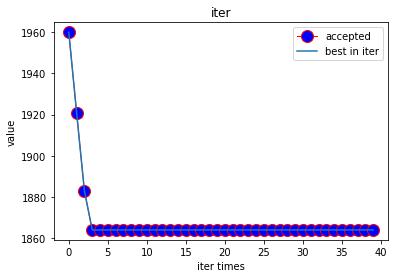

函数:run运行了 2.6089866161346436秒


In [74]:
thisSolution,initlength = generate_first_solution(interCnt=65)
thisSolution,thisLength,saveInit = run(thisSolution, thisLength, 20, 40, 20000, True, True)

In [49]:
thisSolution,initlength = generate_first_solution(interCnt=70)
thisSolution,thisLength,saveInit = run(thisSolution, thisLength, 20, 400, 8000, True, True)


函数：run开始运行：


Searching: 100%|██████████| 400/400 [00:18<00:00, 21.22it/s]


best_value_final: 2521
[[[38, 20], 2521], [[4, 24], 2521]]
[41, 43, 22, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 25, 13, 34, 35, 15, 16, 45, 20, 11, 0, 37, 39, 21, 38, 18, 17, 46, 36, 14, 23, 12, 19, 44]


函数:run运行了 19.04978060722351秒


### 对比接受起始位置的实验
随着**接受位置从第i个值开始**的 的i增加 抖动变大， 但总体在最优值
``` python  
[2169, 2169, 2169, 2169, 2182, 2182, 2182, 2182, 2197, 2169]
```

某次试验采取了大规模的i，但是最终发现开始一段时间最优值的差距不大，也就是说这样接受次优解的行为反倒没有明显性能下降。这可能是由于问题的解空间随机性过强，不具有明显的邻域特性来执行类似于梯度下降的接近策略。

(0.40928745595510807, 2.355980352919042e-05)
判断为低度线性相关


函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.66it/s]


best_value_final: 2218
[[[38, 18], 2218], [[19, 44], 2218], [[17, 18], 2218]]
[46, 36, 14, 16, 45, 20, 38, 17, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 37, 18, 13]


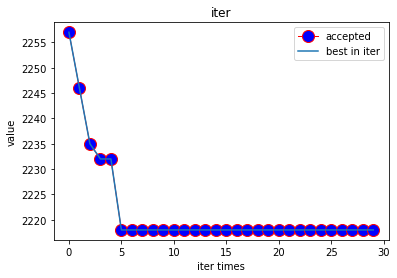

函数:run运行了 1.6496813297271729秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 21.00it/s]


best_value_final: 2218
[[[17, 18], 2218], [[19, 44], 2218], [[18, 37], 2218], [[37, 38], 2218]]
[46, 36, 14, 16, 45, 20, 38, 17, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 37, 18, 13]


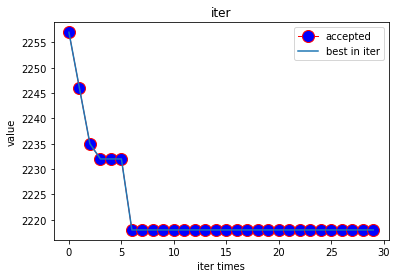

函数:run运行了 1.6561853885650635秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 21.49it/s]


best_value_final: 2218
[[[38, 18], 2218], [[44, 19], 2218], [[17, 18], 2218]]
[46, 36, 14, 16, 45, 20, 38, 17, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 37, 18, 13]


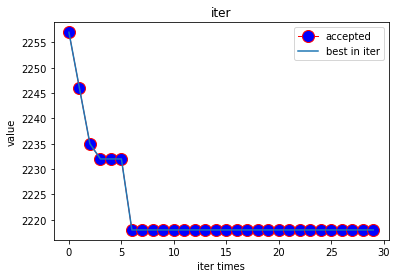

函数:run运行了 1.6042065620422363秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 21.46it/s]


best_value_final: 2218
[[[18, 17], 2218], [[19, 44], 2218], [[37, 18], 2218]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 37, 17, 13]


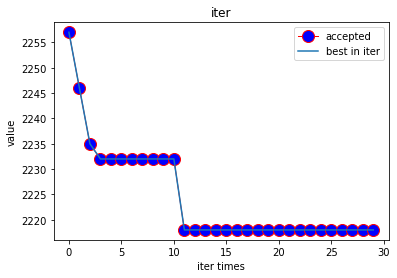

函数:run运行了 1.5990614891052246秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.98it/s]


best_value_final: 2218
[[[10, 11], 2218], [[44, 19], 2224], [[38, 37], 2224]]
[46, 36, 14, 16, 45, 20, 37, 38, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 18, 17, 13]


函数:run运行了 1.6313369274139404秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.67it/s]


best_value_final: 2224
[[[8, 11], 2224], [[37, 38], 2224], [[10, 11], 2224], [[18, 37], 2218]]
[46, 36, 14, 16, 45, 20, 38, 37, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 8, 11, 32, 7, 31, 9, 2, 1, 0, 25, 10, 18, 17, 13]


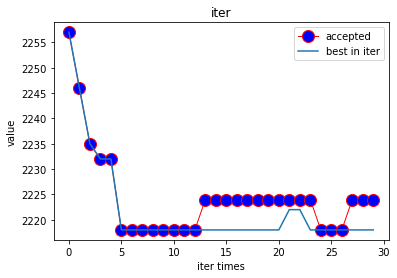

函数:run运行了 1.6493277549743652秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.62it/s]


best_value_final: 2218
[[[37, 11], 2218], [[23, 34], 2221], [[11, 38], 2232]]
[46, 36, 14, 16, 45, 20, 38, 17, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 37, 18, 13]


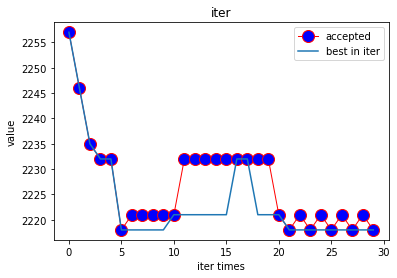

函数:run运行了 1.6672251224517822秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.88it/s]


best_value_final: 2214
[[[44, 19], 2214], [[18, 11], 2214], [[23, 34], 2214]]
[46, 36, 14, 16, 45, 20, 11, 12, 13, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 37, 38, 18, 17]


函数:run运行了 1.618424415588379秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 21.05it/s]


best_value_final: 2232
[[[11, 37], 2232], [[12, 17], 2235], [[13, 23], 2246]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 4, 29, 30, 5, 6, 24, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 37, 17, 13]


函数:run运行了 1.6090309619903564秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.53it/s]


best_value_final: 2232
[[[37, 11], 2232], [[17, 12], 2235], [[23, 13], 2246]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 4, 29, 30, 5, 6, 24, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 37, 17, 13]


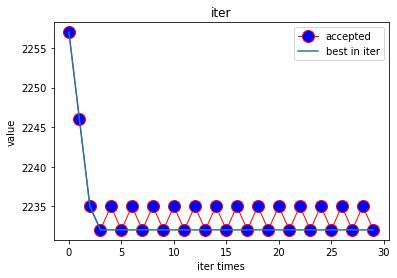

函数:run运行了 1.6473252773284912秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 21.07it/s]


best_value_final: 2117
[[[19, 44], 2117], [[17, 12], 2117], [[24, 3], 2106]]
[46, 36, 14, 16, 45, 20, 38, 18, 17, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 24, 4, 29, 30, 5, 6, 10, 11, 8, 32, 7, 31, 9, 27, 2, 1, 0, 25, 37, 12, 13]


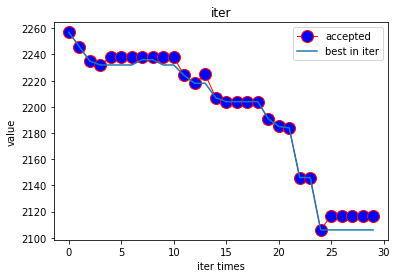

函数:run运行了 1.6214439868927002秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.31it/s]


best_value_final: 2146
[[[33, 27], 2146], [[37, 18], 2146], [[27, 3], 2146]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 4, 3, 33, 24, 29, 30, 5, 6, 10, 11, 8, 32, 7, 31, 9, 27, 2, 1, 0, 25, 37, 17, 13]


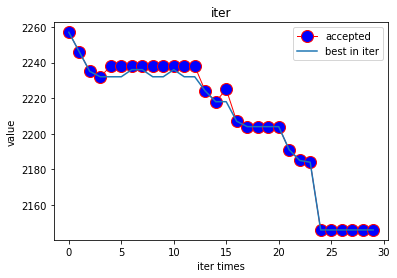

函数:run运行了 1.6656973361968994秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.11it/s]


best_value_final: 2132
[[[28, 2], 2132], [[1, 25], 2132], [[5, 6], 2138]]
[46, 36, 14, 16, 45, 20, 38, 17, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 2, 28, 33, 24, 4, 29, 30, 5, 9, 27, 3, 8, 32, 7, 31, 6, 10, 11, 0, 25, 1, 37, 18, 13]


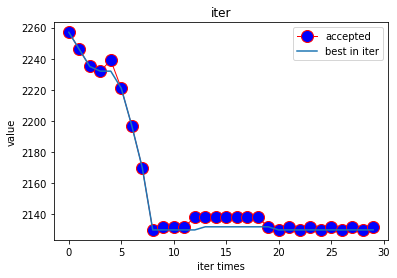

函数:run运行了 1.7274751663208008秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.62it/s]


best_value_final: 2073
[[[13, 12], 2073], [[18, 37], 2073], [[23, 34], 2073], [[2, 28], 2062]]
[46, 36, 14, 16, 45, 20, 38, 18, 13, 34, 23, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 3, 24, 4, 29, 30, 5, 9, 33, 27, 8, 32, 7, 31, 6, 10, 11, 0, 25, 1, 37, 17, 12]


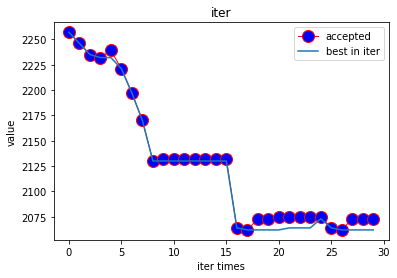

函数:run运行了 1.671428918838501秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.27it/s]


best_value_final: 2193
[[[4, 6], 2193], [[10, 6], 2206], [[28, 2], 2206], [[11, 10], 2204]]
[46, 36, 14, 16, 45, 20, 37, 38, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 2, 28, 33, 3, 24, 29, 30, 5, 6, 10, 11, 8, 32, 7, 31, 9, 27, 4, 0, 25, 1, 18, 17, 13]


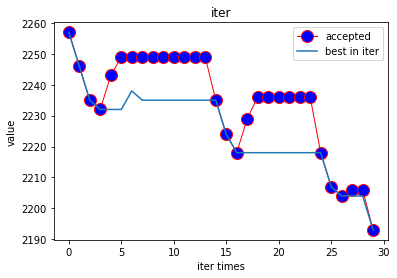

函数:run运行了 1.6845784187316895秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.53it/s]


best_value_final: 2077
[[[10, 11], 2077], [[24, 3], 2051], [[10, 8], 2052], [[27, 33], 2078]]
[46, 36, 14, 16, 45, 20, 38, 12, 7, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 1, 9, 33, 24, 4, 29, 30, 5, 31, 6, 11, 10, 8, 32, 3, 27, 28, 2, 0, 25, 37, 18, 17, 13]


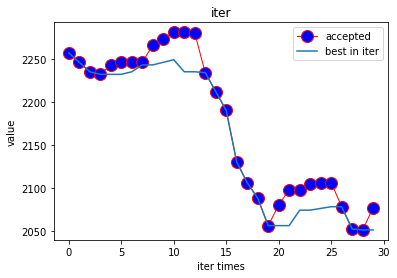

函数:run运行了 1.6528170108795166秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.72it/s]


best_value_final: 2215
[[[3, 2], 2215], [[10, 1], 2233], [[24, 4], 2235], [[13, 12], 2249]]
[46, 36, 14, 16, 45, 20, 38, 18, 13, 34, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 27, 24, 29, 30, 5, 4, 6, 8, 11, 32, 7, 31, 9, 3, 10, 0, 25, 1, 37, 17, 12]


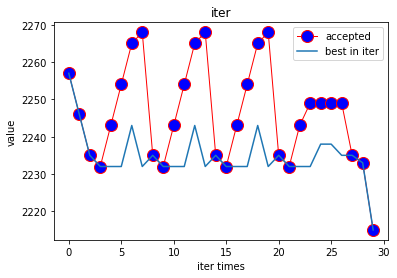

函数:run运行了 1.7236669063568115秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.09it/s]


best_value_final: 2207
[[[12, 17], 2207], [[24, 4], 2218], [[3, 2], 2232], [[23, 34], 2250]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 3, 11, 0, 25, 1, 37, 17, 13]


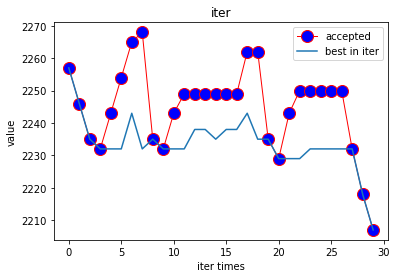

函数:run运行了 1.7049193382263184秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.34it/s]


best_value_final: 2250
[[[19, 44], 2250], [[10, 11], 2250], [[23, 34], 2244]]
[46, 36, 14, 16, 45, 20, 38, 17, 12, 34, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 4, 30, 5, 29, 6, 11, 8, 32, 7, 31, 9, 2, 1, 0, 25, 10, 37, 18, 13]


函数:run运行了 1.6924407482147217秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.43it/s]


best_value_final: 2144
[[[10, 11], 2144], [[3, 2], 2147], [[17, 12], 2165], [[29, 4], 2183]]
[46, 36, 14, 16, 45, 20, 38, 12, 13, 34, 23, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 3, 24, 4, 29, 30, 5, 6, 11, 8, 32, 7, 31, 9, 27, 10, 0, 25, 1, 37, 18, 17]


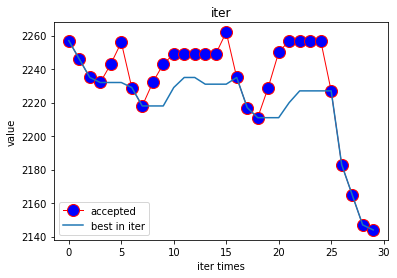

函数:run运行了 1.7459869384765625秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.72it/s]


best_value_final: 2207
[[[12, 13], 2207], [[10, 11], 2218], [[4, 29], 2218]]
[46, 36, 14, 16, 45, 20, 38, 37, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 27, 3, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 33, 11, 0, 25, 1, 18, 17, 13]


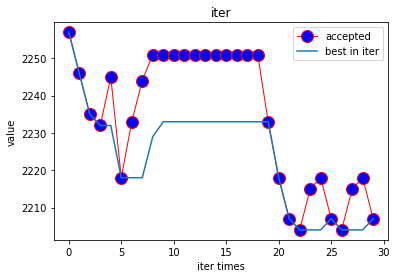

函数:run运行了 1.7278308868408203秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.23it/s]


best_value_final: 2220
[[[34, 23], 2220], [[38, 18], 2220], [[3, 27], 2220], [[6, 24], 2220]]
[46, 36, 14, 16, 45, 20, 38, 12, 13, 34, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 3, 27, 4, 29, 30, 5, 6, 24, 10, 8, 32, 7, 31, 9, 33, 11, 0, 1, 25, 37, 18, 17]


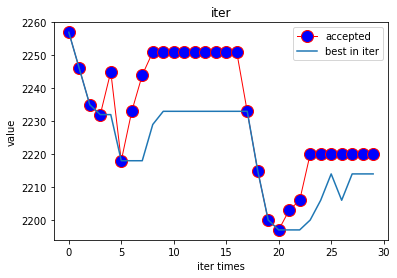

函数:run运行了 1.6992359161376953秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.13it/s]


best_value_final: 2234
[[[33, 27], 2234], [[28, 2], 2234], [[33, 3], 2232], [[4, 24], 2232]]
[46, 36, 14, 16, 45, 20, 38, 18, 13, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 2, 28, 3, 27, 4, 29, 30, 5, 24, 6, 10, 8, 32, 7, 31, 9, 33, 11, 0, 25, 1, 37, 17, 12]


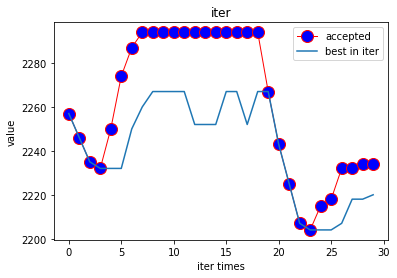

函数:run运行了 1.6902761459350586秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.73it/s]


best_value_final: 2248
[[[27, 3], 2248], [[37, 38], 2248], [[23, 13], 2248]]
[46, 36, 14, 16, 45, 20, 37, 38, 18, 12, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 2, 28, 33, 3, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 27, 11, 0, 1, 25, 17, 23, 13]


函数:run运行了 1.7426695823669434秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.60it/s]


best_value_final: 2201
[[[34, 23], 2201], [[5, 4], 2212], [[9, 4], 2223], [[6, 3], 2223]]
[46, 36, 14, 16, 45, 20, 38, 37, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 2, 28, 33, 27, 24, 29, 30, 4, 9, 3, 8, 11, 32, 7, 31, 5, 6, 10, 0, 1, 25, 18, 17, 13]


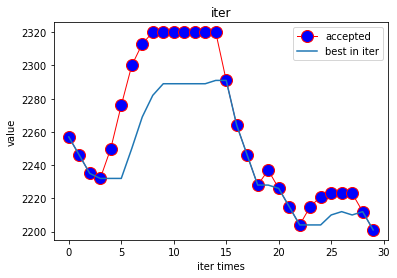

函数:run运行了 1.7552335262298584秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.00it/s]


best_value_final: 2204
[[[28, 2], 2204], [[25, 1], 2206], [[34, 23], 2212], [[4, 29], 2223]]
[46, 36, 14, 16, 45, 20, 37, 38, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 27, 3, 24, 29, 30, 5, 4, 6, 11, 8, 32, 7, 31, 9, 33, 10, 0, 25, 1, 18, 17, 13]


函数:run运行了 1.7974343299865723秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.58it/s]


best_value_final: 2257
[[[13, 23], 2257], [[3, 2], 2233], [[28, 2], 2215], [[25, 1], 2217]]
[46, 36, 14, 16, 45, 20, 37, 38, 23, 34, 13, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 8, 11, 32, 7, 31, 9, 2, 10, 0, 25, 1, 18, 17, 12]


函数:run运行了 1.7384309768676758秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.28it/s]


best_value_final: 2204
[[[2, 28], 2204], [[12, 17], 2206], [[29, 4], 2217], [[37, 18], 2232]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 27, 24, 29, 30, 5, 4, 6, 8, 11, 32, 7, 31, 9, 3, 10, 0, 25, 1, 37, 17, 13]


函数:run运行了 1.7740185260772705秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.74it/s]


best_value_final: 2210
[[[11, 6], 2210], [[28, 2], 2249], [[10, 11], 2247], [[25, 1], 2244]]
[46, 36, 14, 16, 45, 20, 37, 38, 12, 13, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 2, 28, 3, 24, 4, 29, 30, 5, 31, 10, 8, 11, 32, 7, 9, 33, 27, 6, 0, 1, 25, 18, 17, 23]


函数:run运行了 1.7352440357208252秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.93it/s]


best_value_final: 2219
[[[8, 11], 2219], [[27, 28], 2195], [[12, 23], 2177], [[28, 2], 2159]]
[46, 36, 14, 16, 45, 20, 38, 18, 23, 12, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 1, 9, 33, 28, 24, 29, 30, 5, 6, 11, 8, 10, 32, 7, 31, 4, 3, 27, 2, 0, 25, 37, 17, 13]


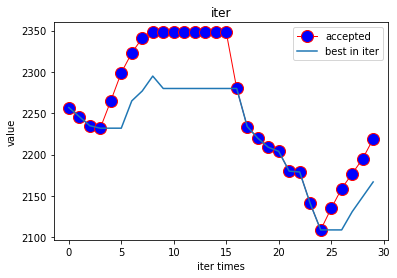

函数:run运行了 1.695441484451294秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.38it/s]


best_value_final: 2215
[[[13, 34], 2215], [[10, 11], 2191], [[29, 4], 2162], [[4, 30], 2206]]
[46, 36, 14, 16, 45, 20, 38, 37, 34, 13, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 27, 24, 4, 29, 30, 5, 6, 8, 10, 32, 7, 31, 9, 3, 11, 0, 25, 1, 18, 17, 12]


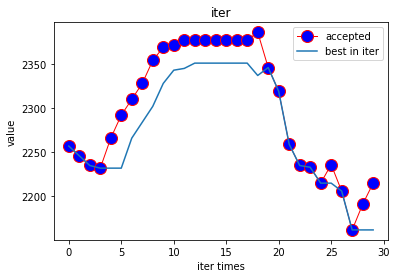

函数:run运行了 1.7605624198913574秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.82it/s]


best_value_final: 2232
[[[34, 13], 2232], [[18, 37], 2278], [[30, 4], 2278], [[25, 1], 2276]]
[46, 36, 14, 16, 45, 20, 38, 18, 17, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 4, 30, 6, 9, 2, 8, 32, 7, 31, 5, 11, 10, 0, 1, 25, 37, 12, 13]


函数:run运行了 1.8071184158325195秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.49it/s]


best_value_final: 2304
[[[30, 24], 2304], [[24, 3], 2291], [[24, 4], 2276], [[37, 10], 2251]]
[46, 36, 14, 16, 45, 20, 38, 18, 17, 13, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 27, 4, 29, 24, 3, 6, 9, 30, 8, 32, 7, 31, 5, 11, 37, 0, 25, 1, 10, 12, 34]


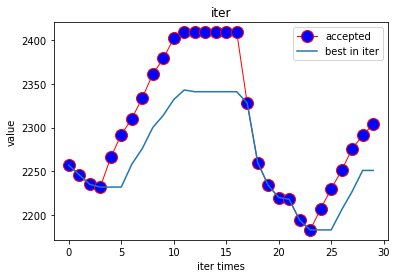

函数:run运行了 1.7481987476348877秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 20.21it/s]


best_value_final: 2180
[[[9, 29], 2180], [[29, 4], 2235], [[4, 2], 2220], [[4, 24], 2202]]
[46, 36, 14, 16, 45, 20, 37, 38, 13, 34, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 9, 33, 27, 2, 24, 4, 30, 5, 6, 11, 8, 32, 7, 31, 29, 3, 10, 0, 25, 1, 18, 17, 12]


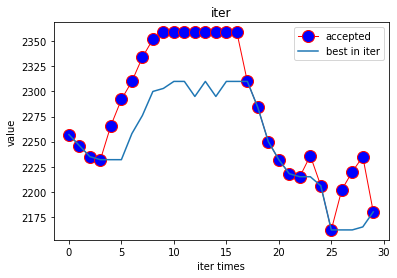

函数:run运行了 1.6865887641906738秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.97it/s]


best_value_final: 2256
[[[12, 13], 2256], [[23, 13], 2245], [[12, 17], 2234], [[30, 4], 2223]]
[46, 36, 14, 16, 45, 20, 38, 18, 17, 12, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 3, 30, 4, 24, 29, 5, 6, 11, 10, 8, 32, 7, 31, 9, 33, 27, 0, 25, 1, 37, 13, 23]


函数:run运行了 1.7567722797393799秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.64it/s]


best_value_final: 2174
[[[29, 4], 2174], [[30, 4], 2218], [[0, 25], 2248], [[37, 18], 2321]]
[46, 36, 14, 16, 45, 20, 38, 37, 23, 12, 13, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 1, 9, 33, 3, 24, 4, 29, 30, 5, 6, 10, 8, 32, 7, 31, 27, 28, 2, 11, 0, 25, 18, 17, 34]


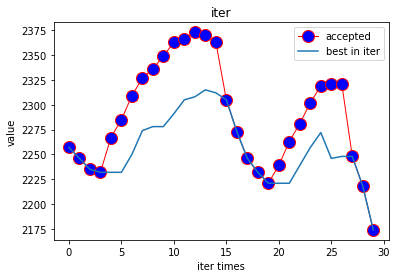

函数:run运行了 1.851853609085083秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.01it/s]


best_value_final: 2306
[[[11, 6], 2306], [[28, 1], 2285], [[8, 10], 2259], [[24, 3], 2233]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 1, 24, 33, 27, 3, 29, 30, 5, 4, 11, 8, 10, 32, 7, 31, 9, 2, 28, 6, 0, 25, 37, 17, 13]


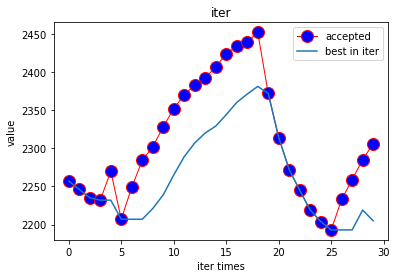

函数:run运行了 1.802382469177246秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.92it/s]


best_value_final: 2229
[[[6, 5], 2229], [[33, 24], 2260], [[34, 23], 2300], [[33, 3], 2352]]
[46, 36, 14, 16, 45, 20, 38, 34, 23, 12, 13, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 33, 3, 24, 4, 29, 30, 5, 7, 31, 6, 11, 32, 8, 9, 27, 2, 1, 10, 0, 25, 37, 18, 17]


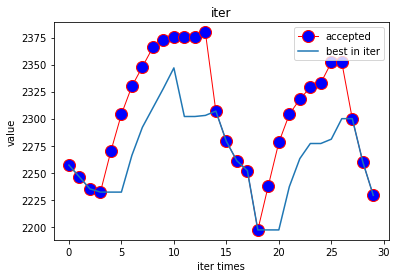

函数:run运行了 1.8216302394866943秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.69it/s]


best_value_final: 2345
[[[3, 4], 2345], [[4, 5], 2327], [[3, 24], 2306], [[15, 16], 2266]]
[46, 36, 14, 15, 45, 20, 38, 18, 7, 23, 34, 35, 16, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 24, 33, 27, 4, 29, 30, 3, 31, 5, 6, 8, 11, 12, 32, 9, 2, 1, 10, 0, 25, 37, 17, 13]


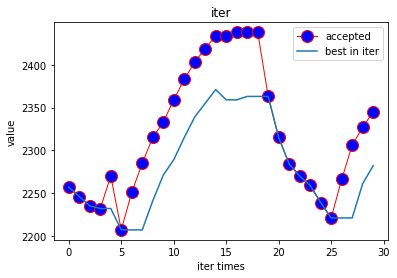

函数:run运行了 1.8033721446990967秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.51it/s]


best_value_final: 2173
[[[14, 15], 2173], [[34, 12], 2218], [[9, 4], 2267], [[23, 12], 2374]]
[46, 36, 14, 16, 45, 20, 38, 37, 13, 34, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 1, 9, 33, 27, 24, 29, 30, 5, 3, 6, 8, 11, 32, 7, 31, 4, 2, 28, 10, 0, 25, 18, 17, 12]


函数:run运行了 1.8243560791015625秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.27it/s]


best_value_final: 2359
[[[4, 6], 2359], [[11, 3], 2345], [[24, 3], 2330], [[3, 2], 2304]]
[46, 36, 14, 16, 45, 20, 38, 17, 23, 12, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 24, 33, 27, 6, 29, 30, 5, 9, 2, 4, 3, 32, 7, 31, 11, 10, 8, 0, 25, 1, 37, 18, 13]


函数:run运行了 1.7839818000793457秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.46it/s]


best_value_final: 2357
[[[24, 9], 2357], [[23, 13], 2348], [[24, 3], 2330], [[2, 3], 2304]]
[46, 36, 14, 16, 45, 20, 38, 37, 13, 12, 23, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 9, 33, 27, 4, 29, 30, 5, 24, 2, 6, 11, 32, 7, 31, 3, 8, 10, 0, 25, 1, 18, 17, 34]


函数:run运行了 1.837660551071167秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.11it/s]


best_value_final: 2135
[[[39, 19], 2135], [[3, 33], 2083], [[24, 27], 2219], [[23, 34], 2191]]
[46, 36, 14, 16, 45, 20, 38, 17, 12, 23, 34, 35, 15, 39, 44, 19, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 3, 24, 4, 29, 30, 5, 6, 10, 11, 8, 32, 7, 31, 9, 33, 27, 0, 25, 1, 37, 18, 13]


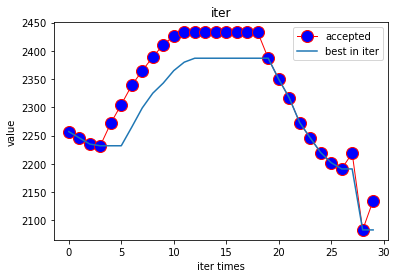

函数:run运行了 1.872910499572754秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.55it/s]


best_value_final: 2295
[[[29, 30], 2295], [[4, 6], 2278], [[29, 6], 2251], [[3, 4], 2224]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 11, 10, 9, 33, 27, 28, 24, 29, 5, 3, 6, 30, 8, 32, 7, 31, 4, 2, 42, 1, 0, 25, 37, 17, 13]


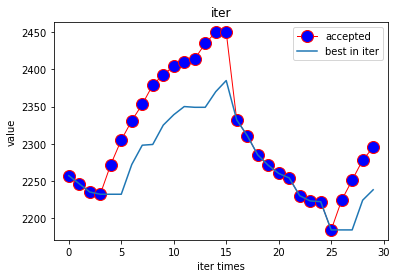

函数:run运行了 1.8221580982208252秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.20it/s]


best_value_final: 2378
[[[10, 6], 2378], [[3, 4], 2344], [[18, 38], 2304], [[14, 15], 2262]]
[46, 36, 15, 16, 45, 20, 37, 18, 17, 12, 23, 35, 14, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 4, 33, 27, 24, 29, 30, 5, 3, 10, 6, 8, 32, 7, 31, 9, 2, 1, 11, 0, 25, 38, 13, 34]


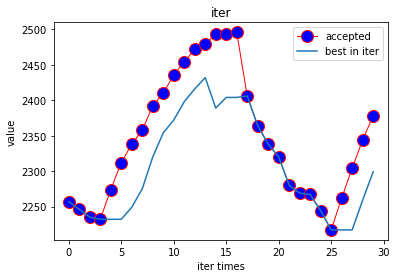

函数:run运行了 1.7763571739196777秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.83it/s]


best_value_final: 2279
[[[13, 23], 2279], [[2, 27], 2246], [[30, 3], 2208], [[5, 29], 2211]]
[46, 36, 14, 16, 45, 20, 37, 38, 12, 13, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 1, 9, 33, 2, 24, 4, 3, 29, 30, 6, 10, 8, 32, 7, 31, 5, 27, 28, 0, 25, 11, 18, 17, 23]


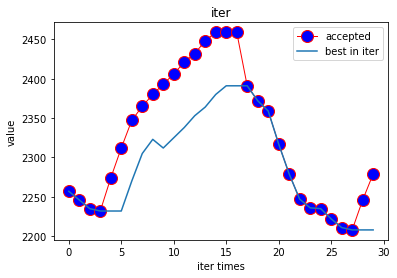

函数:run运行了 1.8246517181396484秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.28it/s]


best_value_final: 2268
[[[13, 34], 2268], [[1, 25], 2314], [[10, 11], 2308], [[2, 28], 2305]]
[46, 36, 15, 16, 45, 20, 37, 38, 12, 23, 34, 35, 14, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 2, 9, 33, 27, 28, 3, 29, 30, 4, 6, 10, 8, 32, 7, 31, 5, 24, 11, 0, 1, 25, 18, 17, 13]


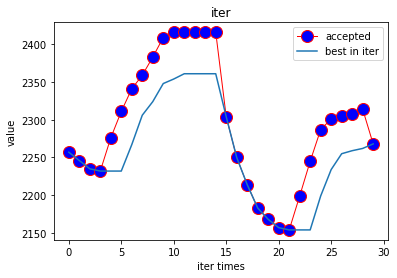

函数:run运行了 1.776777744293213秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.00it/s]


best_value_final: 2249
[[[2, 6], 2249], [[2, 42], 2302], [[42, 10], 2394], [[23, 34], 2387]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 34, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 9, 33, 27, 4, 30, 5, 29, 24, 3, 2, 8, 32, 7, 31, 6, 10, 11, 0, 25, 1, 37, 17, 13]


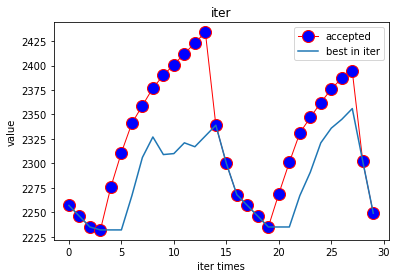

函数:run运行了 1.8163683414459229秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.71it/s]


best_value_final: 2339
[[[4, 10], 2339], [[6, 10], 2312], [[24, 3], 2278], [[37, 0], 2238]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 33, 27, 24, 3, 29, 30, 5, 10, 4, 6, 8, 32, 7, 31, 9, 2, 25, 1, 11, 0, 37, 17, 13]


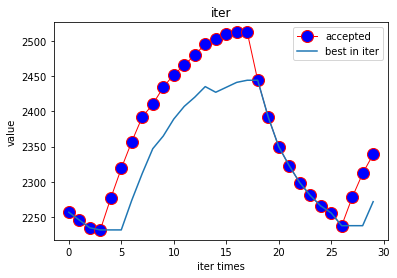

函数:run运行了 1.8929462432861328秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.39it/s]


best_value_final: 2272
[[[10, 6], 2272], [[5, 4], 2296], [[3, 6], 2360], [[3, 2], 2334]]
[46, 36, 15, 16, 45, 20, 38, 18, 12, 23, 34, 35, 14, 39, 19, 44, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 9, 33, 27, 29, 30, 4, 3, 24, 6, 8, 32, 7, 31, 5, 10, 1, 11, 37, 0, 25, 17, 13]


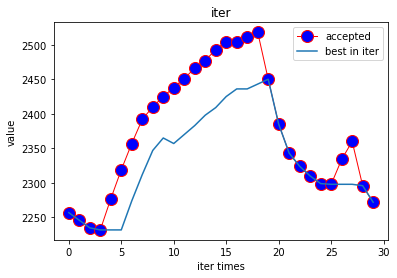

函数:run运行了 1.854994297027588秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.62it/s]


best_value_final: 2485
[[[27, 4], 2485], [[3, 4], 2457], [[16, 15], 2417], [[29, 4], 2372]]
[46, 36, 14, 15, 45, 20, 11, 0, 17, 7, 23, 35, 16, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 27, 33, 4, 29, 30, 5, 31, 8, 10, 24, 3, 12, 32, 6, 9, 2, 1, 25, 37, 38, 18, 13, 34]


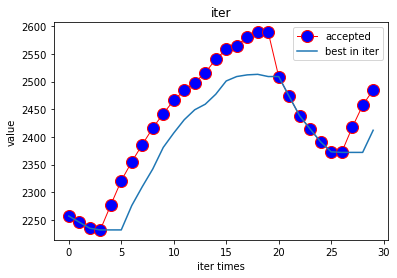

函数:run运行了 1.8573510646820068秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.83it/s]


best_value_final: 2278
[[[33, 6], 2278], [[24, 3], 2255], [[29, 4], 2215], [[33, 9], 2171]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 13, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 3, 29, 4, 30, 6, 9, 27, 24, 33, 8, 32, 7, 31, 5, 10, 11, 37, 0, 25, 1, 17, 34]


函数:run运行了 1.8111743927001953秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.33it/s]


best_value_final: 2380
[[[12, 13], 2380], [[13, 23], 2344], [[24, 10], 2311], [[2, 29], 2284]]
[46, 36, 14, 16, 45, 20, 38, 18, 13, 12, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 29, 33, 27, 2, 4, 30, 5, 6, 24, 11, 8, 32, 7, 31, 9, 3, 10, 37, 0, 25, 1, 17, 23]


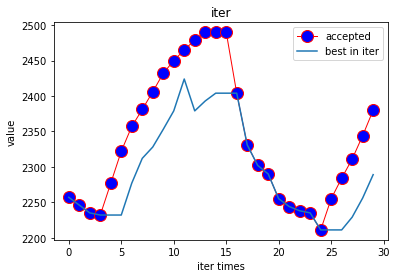

函数:run运行了 1.849522352218628秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.94it/s]


best_value_final: 2242
[[[5, 30], 2242], [[29, 33], 2208], [[2, 28], 2168], [[25, 1], 2170]]
[46, 36, 14, 16, 45, 20, 37, 38, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 9, 27, 2, 28, 4, 33, 29, 3, 24, 5, 11, 8, 32, 7, 31, 30, 6, 10, 0, 25, 1, 18, 17, 13]


函数:run运行了 1.8155269622802734秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.59it/s]


best_value_final: 2370
[[[24, 9], 2370], [[24, 3], 2343], [[29, 4], 2303], [[19, 39], 2259]]
[46, 36, 14, 16, 45, 20, 38, 18, 13, 34, 23, 35, 15, 39, 44, 19, 21, 40, 47, 26, 22, 41, 43, 42, 28, 9, 33, 3, 29, 4, 30, 5, 10, 6, 11, 8, 32, 7, 31, 24, 27, 2, 1, 37, 0, 25, 17, 12]


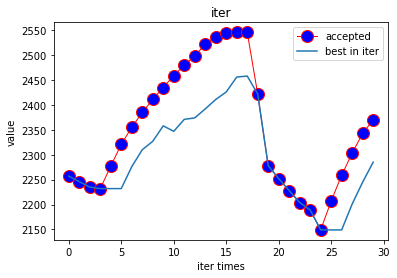

函数:run运行了 1.7634642124176025秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.56it/s]


best_value_final: 2359
[[[9, 27], 2359], [[25, 1], 2356], [[9, 29], 2350], [[24, 29], 2326]]
[46, 36, 15, 16, 45, 20, 38, 18, 12, 23, 13, 35, 14, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 9, 3, 24, 30, 5, 6, 10, 11, 8, 32, 7, 31, 29, 27, 4, 0, 1, 25, 37, 17, 34]


函数:run运行了 1.8383874893188477秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 19.18it/s]


best_value_final: 2217
[[[9, 33], 2217], [[22, 42], 2164], [[0, 25], 2106], [[1, 0], 2144]]
[46, 36, 14, 16, 45, 20, 38, 37, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 42, 41, 43, 22, 28, 3, 9, 24, 4, 29, 30, 5, 6, 10, 11, 8, 32, 7, 31, 33, 27, 2, 1, 0, 25, 18, 17, 13]


函数:run运行了 1.8067138195037842秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.87it/s]


best_value_final: 2312
[[[25, 0], 2312], [[27, 24], 2277], [[25, 1], 2237], [[15, 14], 2192]]
[46, 36, 15, 16, 45, 20, 38, 18, 12, 23, 34, 35, 14, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 27, 4, 29, 30, 5, 9, 24, 3, 8, 32, 7, 31, 6, 10, 25, 1, 0, 11, 37, 17, 13]


函数:run运行了 1.7900280952453613秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.75it/s]


best_value_final: 2408
[[[3, 24], 2408], [[39, 45], 2368], [[8, 10], 2326], [[47, 40], 2276]]
[46, 36, 14, 15, 39, 20, 38, 18, 12, 23, 34, 35, 16, 45, 19, 44, 21, 47, 40, 26, 22, 41, 43, 42, 28, 24, 3, 4, 29, 30, 6, 9, 33, 27, 10, 11, 32, 7, 31, 5, 2, 1, 8, 0, 25, 37, 17, 13]


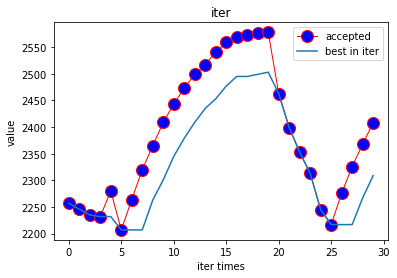

函数:run运行了 1.9397697448730469秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 18.06it/s]


best_value_final: 2295
[[[5, 4], 2295], [[39, 19], 2253], [[29, 4], 2201], [[34, 23], 2202]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 39, 44, 19, 21, 40, 47, 26, 22, 41, 43, 9, 28, 3, 33, 27, 24, 29, 30, 4, 6, 10, 11, 8, 32, 7, 31, 5, 2, 42, 1, 0, 25, 37, 17, 13]


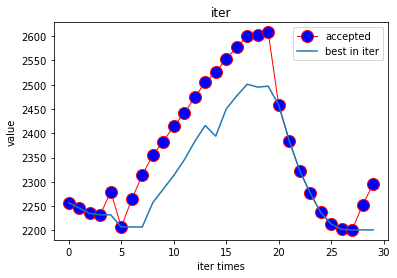

函数:run运行了 2.021306037902832秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.47it/s]


best_value_final: 2332
[[[46, 35], 2332], [[46, 12], 2292], [[23, 36], 2247], [[14, 35], 2191]]
[12, 23, 46, 16, 45, 20, 38, 18, 13, 34, 36, 14, 15, 19, 44, 39, 21, 47, 40, 26, 22, 41, 43, 42, 28, 2, 3, 24, 4, 29, 30, 5, 9, 33, 27, 8, 32, 7, 31, 6, 10, 11, 0, 25, 1, 37, 17, 35]


函数:run运行了 2.0585689544677734秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.27it/s]


best_value_final: 2141
[[[0, 25], 2141], [[0, 1], 2179], [[11, 8], 2180], [[10, 8], 2204]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 28, 3, 9, 33, 27, 24, 29, 30, 5, 6, 10, 11, 8, 32, 7, 31, 4, 2, 42, 1, 0, 25, 37, 17, 13]


函数:run运行了 1.9704546928405762秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.71it/s]


best_value_final: 2186
[[[1, 3], 2186], [[3, 9], 2251], [[34, 23], 2261], [[4, 24], 2272]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 1, 9, 33, 27, 28, 24, 30, 5, 4, 6, 10, 8, 32, 7, 31, 29, 2, 3, 11, 0, 25, 37, 17, 13]


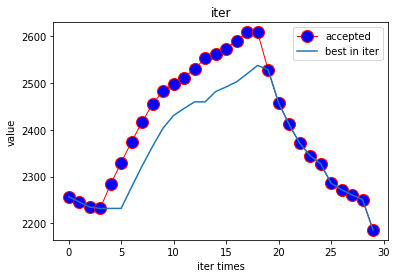

函数:run运行了 1.9143235683441162秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.38it/s]


best_value_final: 2240
[[[42, 22], 2240], [[12, 17], 2182], [[19, 44], 2193], [[24, 4], 2207]]
[46, 36, 14, 15, 45, 20, 0, 18, 12, 23, 34, 35, 16, 39, 19, 44, 21, 40, 47, 26, 42, 41, 43, 22, 28, 3, 33, 24, 4, 29, 30, 5, 6, 10, 11, 8, 32, 7, 31, 9, 27, 2, 1, 25, 37, 38, 17, 13]


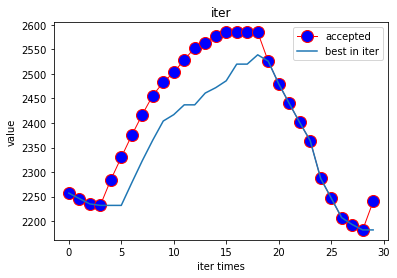

函数:run运行了 1.9774200916290283秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.01it/s]


best_value_final: 2464
[[[0, 11], 2464], [[10, 6], 2447], [[27, 29], 2423], [[4, 8], 2394]]
[46, 36, 14, 16, 45, 20, 38, 18, 23, 12, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 8, 10, 29, 27, 30, 9, 33, 2, 3, 24, 4, 32, 7, 31, 5, 6, 11, 1, 25, 0, 37, 17, 13]


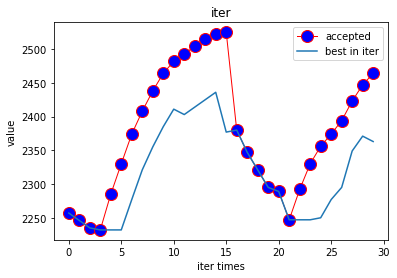

函数:run运行了 1.9957304000854492秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.20it/s]


best_value_final: 2382
[[[38, 18], 2382], [[4, 33], 2340], [[13, 12], 2290], [[8, 10], 2301]]
[46, 36, 14, 16, 45, 20, 11, 38, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 29, 30, 5, 24, 33, 6, 10, 9, 27, 8, 32, 7, 31, 4, 2, 1, 0, 25, 37, 18, 17, 13]


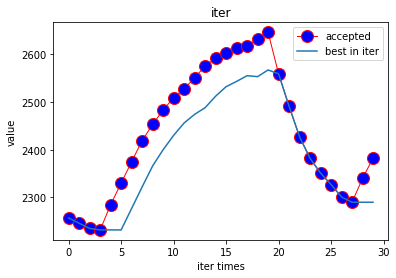

函数:run运行了 1.9799208641052246秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.04it/s]


best_value_final: 2136
[[[24, 3], 2136], [[29, 24], 2176], [[39, 19], 2204], [[44, 45], 2275]]
[23, 34, 35, 16, 45, 20, 38, 17, 13, 46, 36, 14, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 1, 9, 33, 27, 24, 4, 30, 5, 6, 8, 11, 10, 32, 7, 31, 29, 2, 28, 3, 0, 25, 37, 18, 12]


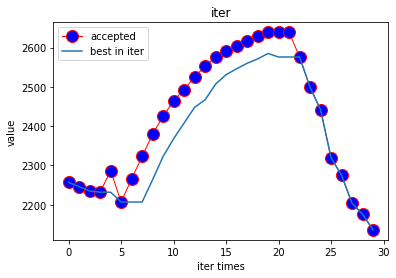

函数:run运行了 2.006782293319702秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.91it/s]


best_value_final: 2301
[[[27, 3], 2301], [[8, 12], 2319], [[6, 4], 2344], [[14, 35], 2371]]
[34, 35, 14, 16, 45, 20, 38, 18, 17, 13, 46, 36, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 9, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 3, 2, 25, 1, 0, 37, 11, 12, 23]


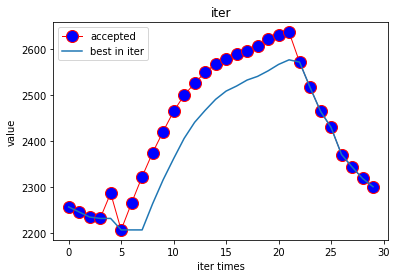

函数:run运行了 2.0429863929748535秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.46it/s]


best_value_final: 2282
[[[3, 9], 2282], [[1, 25], 2229], [[12, 13], 2235], [[2, 3], 2246]]
[46, 36, 14, 15, 45, 20, 38, 18, 12, 23, 34, 35, 16, 39, 19, 44, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 27, 4, 29, 30, 5, 6, 10, 11, 8, 32, 7, 31, 3, 9, 24, 0, 25, 1, 37, 17, 13]


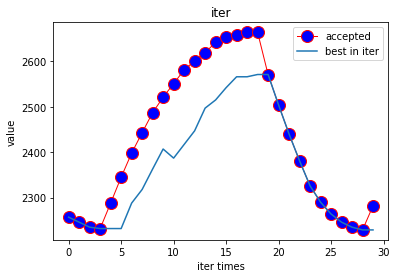

函数:run运行了 1.9491572380065918秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.53it/s]


best_value_final: 2235
[[[40, 47], 2235], [[3, 4], 2176], [[27, 24], 2256], [[3, 2], 2310]]
[46, 36, 14, 16, 45, 20, 38, 18, 17, 34, 23, 35, 15, 19, 44, 39, 21, 47, 40, 26, 22, 41, 43, 42, 28, 2, 3, 9, 33, 27, 30, 5, 6, 10, 11, 8, 32, 7, 31, 24, 4, 29, 0, 25, 1, 37, 12, 13]


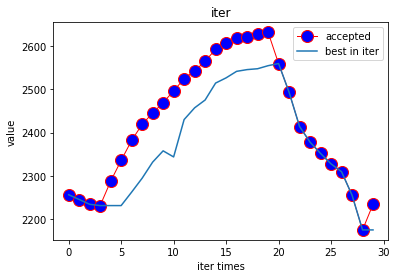

函数:run运行了 1.9318828582763672秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.02it/s]


best_value_final: 2469
[[[6, 30], 2469], [[30, 29], 2432], [[15, 16], 2389], [[8, 11], 2344]]
[46, 36, 14, 15, 45, 20, 38, 18, 12, 23, 34, 35, 16, 19, 39, 44, 21, 40, 47, 22, 26, 41, 43, 42, 8, 10, 9, 33, 27, 3, 24, 4, 6, 29, 30, 11, 32, 7, 31, 5, 2, 28, 0, 25, 1, 37, 17, 13]


函数:run运行了 2.0205376148223877秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.57it/s]


best_value_final: 2401
[[[4, 2], 2401], [[39, 45], 2365], [[4, 24], 2323], [[26, 47], 2270]]
[46, 36, 15, 16, 39, 20, 38, 18, 12, 23, 34, 35, 14, 45, 19, 44, 21, 40, 26, 47, 22, 41, 43, 42, 28, 9, 33, 27, 4, 29, 30, 5, 6, 2, 24, 3, 32, 7, 31, 8, 11, 0, 25, 1, 10, 37, 17, 13]


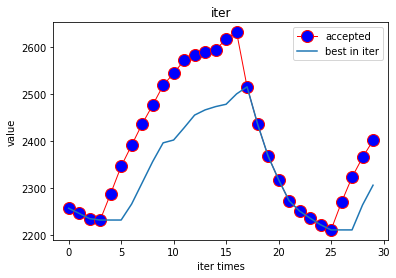

函数:run运行了 2.035748243331909秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.35it/s]


best_value_final: 2306
[[[42, 26], 2306], [[35, 14], 2248], [[32, 12], 2189]]
[46, 36, 35, 16, 45, 20, 37, 38, 18, 23, 34, 14, 15, 44, 19, 39, 21, 40, 47, 42, 22, 41, 43, 26, 1, 9, 27, 3, 24, 29, 30, 5, 6, 8, 11, 32, 12, 7, 31, 33, 2, 28, 4, 10, 0, 25, 17, 13]


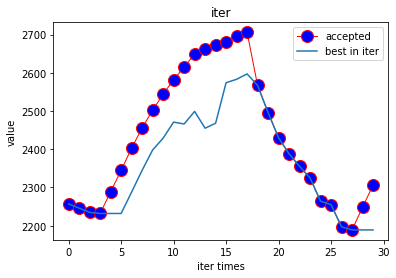

函数:run运行了 1.9953193664550781秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.39it/s]


best_value_final: 2257
[[[33, 9], 2257], [[34, 23], 2260], [[8, 10], 2271], [[4, 6], 2297]]
[46, 36, 14, 16, 45, 20, 11, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 9, 33, 27, 24, 30, 5, 4, 6, 10, 8, 32, 7, 31, 29, 2, 1, 0, 25, 37, 38, 17, 13]


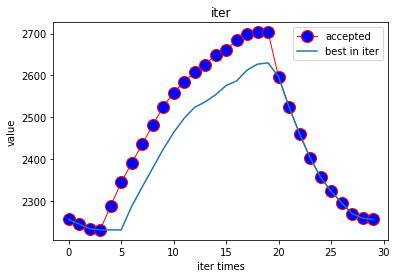

函数:run运行了 1.9807515144348145秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.59it/s]


best_value_final: 2337
[[[9, 27], 2337], [[12, 13], 2281], [[4, 24], 2292], [[44, 19], 2306]]
[46, 36, 14, 15, 19, 20, 38, 18, 12, 23, 34, 35, 16, 45, 39, 44, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 9, 24, 29, 30, 5, 4, 6, 8, 11, 32, 7, 31, 27, 2, 0, 25, 1, 10, 37, 17, 13]


函数:run运行了 1.9491491317749023秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.26it/s]


best_value_final: 2249
[[[37, 11], 2249], [[4, 29], 2273], [[23, 12], 2317], [[1, 37], 2375]]
[46, 36, 14, 16, 45, 20, 38, 18, 13, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 6, 24, 4, 29, 30, 5, 33, 27, 10, 8, 32, 7, 31, 9, 2, 1, 11, 37, 0, 25, 17, 12]


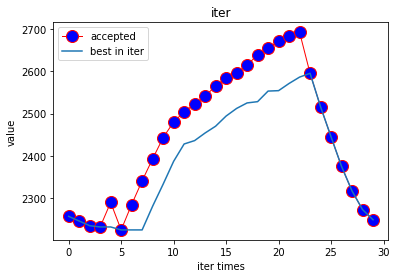

函数:run运行了 1.9532897472381592秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.65it/s]


best_value_final: 2342
[[[12, 34], 2342], [[37, 11], 2360], [[29, 4], 2384], [[4, 30], 2413]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 6, 31, 30, 5, 10, 9, 3, 24, 4, 29, 8, 32, 7, 33, 27, 2, 1, 11, 37, 0, 25, 17, 13]


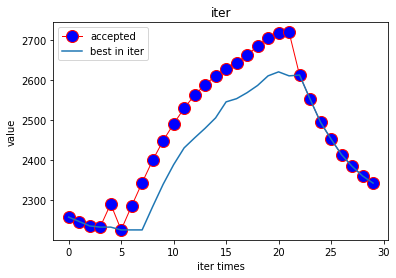

函数:run运行了 2.0542516708374023秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.70it/s]


best_value_final: 2216
[[[24, 11], 2216], [[10, 4], 2274], [[39, 44], 2307], [[7, 32], 2364]]
[46, 36, 14, 16, 45, 20, 38, 18, 17, 13, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 4, 33, 27, 29, 30, 5, 6, 24, 8, 11, 10, 32, 31, 9, 2, 1, 0, 25, 37, 12, 7, 23]


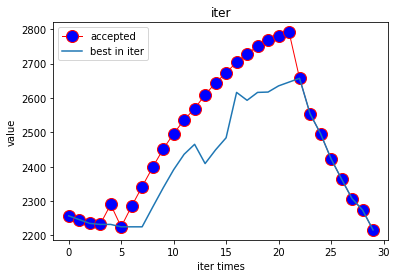

函数:run运行了 2.077543020248413秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.50it/s]


best_value_final: 2261
[[[34, 12], 2261], [[23, 13], 2274], [[8, 10], 2283], [[10, 11], 2309]]
[46, 36, 14, 16, 45, 20, 38, 18, 17, 34, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 6, 24, 4, 29, 30, 5, 10, 9, 27, 8, 32, 7, 31, 33, 2, 1, 0, 25, 37, 11, 12, 13]


函数:run运行了 2.1219935417175293秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.54it/s]


best_value_final: 2250
[[[3, 2], 2250], [[10, 8], 2268], [[15, 16], 2294], [[13, 34], 2339]]
[46, 36, 14, 16, 45, 20, 38, 18, 17, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 27, 24, 4, 30, 5, 29, 10, 11, 8, 32, 7, 31, 9, 3, 6, 37, 0, 25, 1, 12, 13]


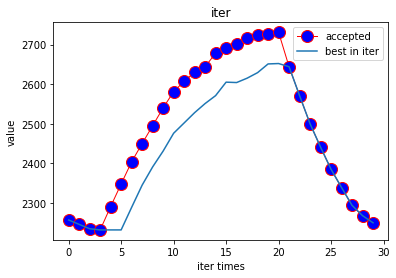

函数:run运行了 2.096045970916748秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.64it/s]


best_value_final: 2284
[[[34, 12], 2284], [[2, 28], 2302], [[22, 42], 2324], [[6, 10], 2352]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 26, 42, 22, 41, 43, 47, 1, 9, 33, 3, 24, 29, 30, 5, 31, 6, 10, 8, 32, 7, 4, 27, 28, 2, 0, 25, 11, 37, 17, 13]


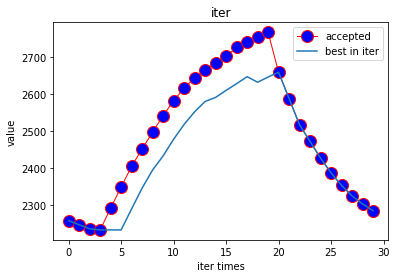

函数:run运行了 2.0558037757873535秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.66it/s]


best_value_final: 2172
[[[29, 4], 2172], [[17, 12], 2187], [[1, 0], 2205], [[0, 11], 2240]]
[23, 34, 35, 16, 45, 20, 38, 18, 17, 46, 36, 14, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 9, 33, 27, 2, 29, 30, 5, 3, 24, 4, 8, 32, 7, 31, 6, 10, 11, 0, 1, 25, 37, 12, 13]


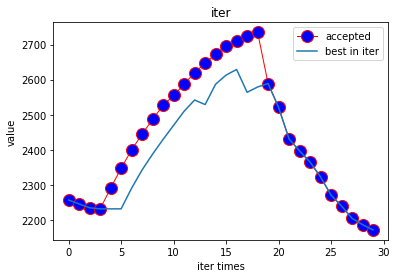

函数:run运行了 2.079249858856201秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.54it/s]


best_value_final: 2313
[[[6, 5], 2313], [[8, 11], 2331], [[18, 38], 2355], [[22, 47], 2397]]
[46, 36, 14, 16, 45, 20, 38, 7, 23, 13, 34, 35, 15, 44, 19, 39, 21, 26, 40, 47, 22, 41, 43, 42, 28, 3, 33, 27, 4, 29, 24, 5, 31, 30, 6, 10, 11, 8, 32, 9, 2, 1, 37, 0, 25, 18, 17, 12]


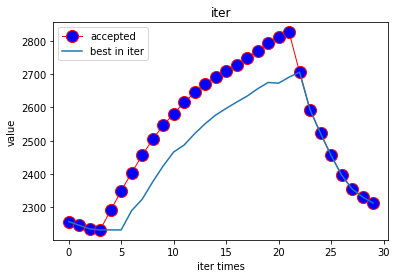

函数:run运行了 2.0985403060913086秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.61it/s]


best_value_final: 2332
[[[8, 6], 2332], [[13, 12], 2366], [[30, 5], 2402], [[6, 30], 2467]]
[13, 46, 36, 16, 45, 20, 38, 18, 14, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 29, 33, 27, 3, 24, 4, 30, 5, 6, 8, 10, 32, 7, 31, 9, 2, 1, 25, 11, 37, 0, 17, 12]


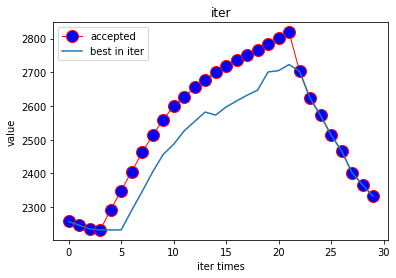

函数:run运行了 2.073441743850708秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.63it/s]


best_value_final: 2171
[[[12, 13], 2171], [[24, 4], 2182], [[1, 25], 2196], [[10, 38], 2241]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 9, 27, 2, 28, 24, 29, 30, 5, 4, 3, 33, 6, 32, 7, 31, 8, 11, 0, 25, 1, 10, 37, 17, 13]


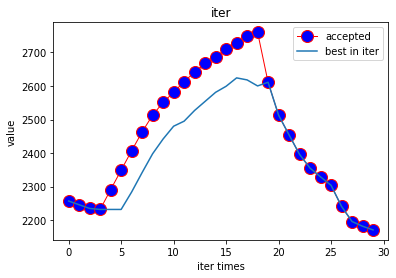

函数:run运行了 2.0645248889923096秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.65it/s]


best_value_final: 2468
[[[45, 39], 2468], [[5, 29], 2426], [[22, 26], 2371], [[3, 2], 2312]]
[46, 36, 14, 15, 39, 20, 38, 18, 12, 23, 34, 35, 16, 45, 19, 44, 21, 40, 47, 22, 26, 41, 43, 42, 0, 25, 1, 9, 4, 5, 30, 29, 33, 27, 6, 8, 32, 7, 31, 2, 28, 3, 24, 10, 11, 37, 17, 13]


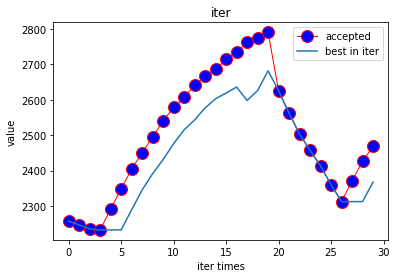

函数:run运行了 2.0709128379821777秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.35it/s]


best_value_final: 2195
[[[17, 12], 2195], [[29, 4], 2206], [[1, 0], 2221], [[0, 11], 2256]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 2, 33, 9, 27, 29, 30, 5, 7, 31, 24, 4, 3, 8, 32, 6, 10, 11, 0, 1, 25, 37, 17, 13]


函数:run运行了 1.9709267616271973秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.48it/s]


best_value_final: 2438
[[[25, 1], 2438], [[4, 30], 2400], [[3, 6], 2360], [[0, 37], 2307]]
[46, 36, 15, 16, 45, 20, 38, 18, 12, 23, 34, 35, 14, 39, 19, 44, 21, 40, 47, 26, 22, 41, 43, 42, 28, 9, 33, 27, 2, 24, 4, 31, 3, 8, 32, 7, 5, 30, 29, 6, 10, 11, 37, 1, 25, 0, 17, 13]


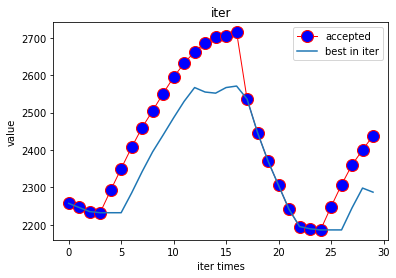

函数:run运行了 1.9509234428405762秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.06it/s]


best_value_final: 2328
[[[8, 10], 2328], [[1, 42], 2330], [[40, 47], 2369], [[44, 19], 2380]]
[46, 36, 15, 16, 45, 0, 25, 18, 12, 23, 34, 35, 14, 39, 19, 44, 21, 47, 26, 1, 22, 41, 43, 28, 24, 3, 33, 27, 4, 29, 30, 5, 6, 10, 8, 11, 32, 7, 31, 9, 2, 42, 40, 20, 38, 37, 17, 13]


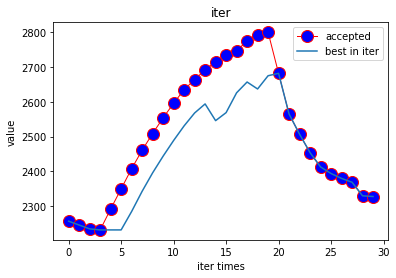

函数:run运行了 2.0014419555664062秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.86it/s]


best_value_final: 2444
[[[19, 45], 2444], [[34, 13], 2463], [[24, 4], 2509], [[30, 5], 2562]]
[46, 36, 14, 15, 45, 20, 38, 18, 12, 23, 34, 35, 16, 19, 44, 39, 21, 40, 42, 22, 41, 43, 47, 26, 28, 2, 1, 10, 24, 4, 29, 30, 5, 3, 33, 8, 32, 7, 31, 9, 27, 6, 0, 25, 37, 11, 17, 13]


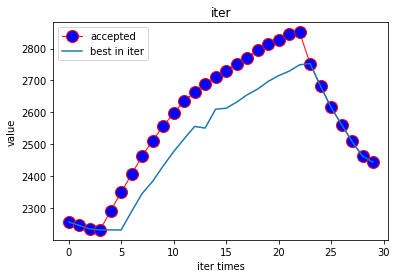

函数:run运行了 2.061950206756592秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.20it/s]


best_value_final: 2171
[[[2, 3], 2171], [[29, 4], 2182], [[11, 8], 2183], [[23, 13], 2207]]
[46, 36, 14, 16, 45, 20, 0, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 1, 9, 33, 27, 24, 29, 30, 5, 6, 10, 11, 8, 32, 7, 31, 4, 3, 28, 2, 25, 37, 38, 17, 13]


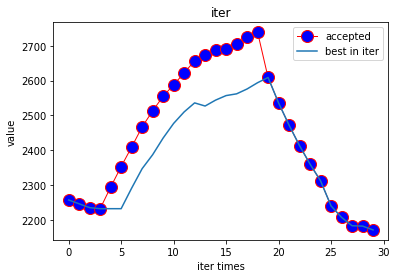

函数:run运行了 2.0034618377685547秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.91it/s]


best_value_final: 2191
[[[6, 8], 2191], [[39, 19], 2225], [[26, 47], 2277], [[30, 29], 2336]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 7, 23, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 9, 33, 3, 6, 24, 29, 30, 5, 8, 10, 11, 32, 31, 4, 27, 2, 1, 0, 25, 37, 17, 13, 34]


函数:run运行了 2.0223395824432373秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.05it/s]


best_value_final: 2471
[[[26, 22], 2471], [[20, 38], 2412], [[16, 45], 2348], [[31, 5], 2281]]
[34, 35, 14, 45, 16, 38, 20, 18, 7, 23, 46, 36, 15, 19, 44, 39, 21, 40, 47, 22, 26, 41, 43, 42, 28, 3, 33, 27, 4, 6, 24, 29, 30, 5, 31, 12, 32, 8, 10, 9, 2, 1, 0, 25, 11, 37, 17, 13]


函数:run运行了 1.9768943786621094秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.00it/s]


best_value_final: 2502
[[[8, 10], 2502], [[0, 25], 2528], [[16, 15], 2563], [[5, 4], 2608]]
[46, 36, 14, 15, 19, 20, 0, 18, 13, 23, 34, 35, 16, 45, 39, 44, 21, 40, 47, 22, 42, 41, 43, 26, 6, 24, 33, 27, 28, 3, 4, 30, 5, 29, 10, 8, 32, 7, 31, 9, 2, 1, 25, 37, 38, 11, 17, 12]


函数:run运行了 2.0086140632629395秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.82it/s]


best_value_final: 2435
[[[9, 8], 2435], [[12, 34], 2448], [[47, 26], 2466], [[42, 40], 2485]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 0, 25, 47, 22, 41, 43, 42, 11, 9, 33, 27, 28, 4, 29, 30, 6, 8, 3, 24, 32, 7, 31, 5, 2, 40, 26, 1, 10, 37, 17, 13]


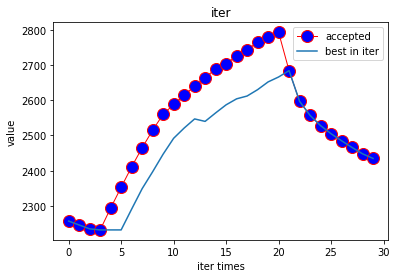

函数:run运行了 2.0342049598693848秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 17.16it/s]


best_value_final: 2326
[[[28, 24], 2326], [[38, 20], 2264], [[24, 4], 2200], [[24, 27], 2214]]
[46, 36, 14, 16, 45, 38, 20, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 24, 3, 6, 9, 33, 27, 28, 29, 30, 5, 10, 8, 32, 7, 31, 4, 2, 1, 0, 25, 11, 37, 17, 13]


函数:run运行了 1.989823818206787秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.84it/s]


best_value_final: 2447
[[[11, 25], 2447], [[31, 6], 2392], [[13, 23], 2330], [[34, 12], 2266]]
[12, 23, 46, 16, 45, 20, 38, 18, 17, 36, 35, 14, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 4, 29, 30, 5, 31, 24, 10, 8, 32, 7, 6, 9, 2, 1, 0, 11, 25, 37, 34, 13]


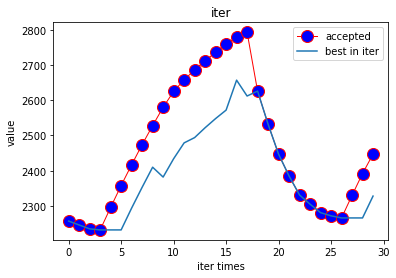

函数:run运行了 2.0245487689971924秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.63it/s]


best_value_final: 2402
[[[6, 10], 2402], [[42, 26], 2344], [[28, 9], 2286], [[9, 33], 2226]]
[46, 36, 14, 16, 45, 20, 38, 18, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 42, 22, 41, 43, 26, 9, 28, 33, 27, 2, 29, 30, 5, 24, 4, 3, 8, 32, 7, 31, 10, 25, 1, 6, 11, 0, 37, 17, 13]


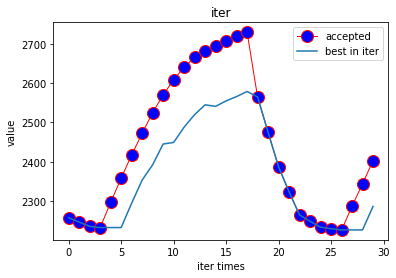

函数:run运行了 2.0281834602355957秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.68it/s]


best_value_final: 2437
[[[38, 37], 2437], [[11, 38], 2479], [[8, 9], 2501], [[34, 13], 2529]]
[46, 36, 14, 16, 39, 21, 20, 17, 12, 23, 34, 35, 15, 45, 19, 44, 38, 40, 47, 26, 22, 41, 43, 1, 27, 28, 3, 24, 4, 29, 30, 5, 6, 9, 10, 8, 32, 7, 31, 33, 2, 42, 11, 0, 25, 37, 18, 13]


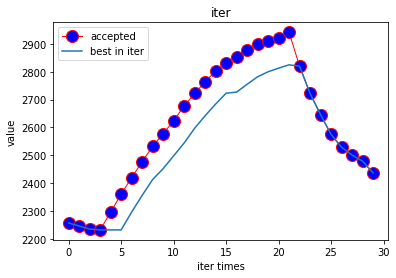

函数:run运行了 2.0552923679351807秒

函数：run开始运行：


Searching: 100%|██████████| 30/30 [00:01<00:00, 16.88it/s]


best_value_final: 2275
[[[12, 17], 2275], [[6, 11], 2203], [[11, 10], 2120], [[15, 16], 2139]]
[46, 36, 14, 16, 45, 20, 38, 17, 7, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 24, 4, 29, 30, 31, 5, 11, 8, 6, 18, 32, 9, 33, 27, 2, 1, 10, 37, 0, 25, 12, 13]


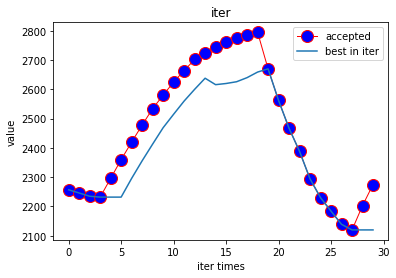

函数:run运行了 2.031317949295044秒


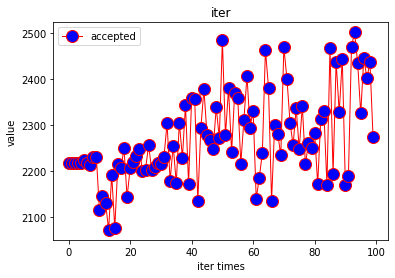

[[2218,
  2218,
  2218,
  2218,
  2218,
  2224,
  2218,
  2214,
  2232,
  2232,
  2117,
  2146,
  2132,
  2073,
  2193,
  2077,
  2215,
  2207,
  2250,
  2144,
  2207,
  2220,
  2234,
  2248,
  2201,
  2204,
  2257,
  2204,
  2210,
  2219,
  2215,
  2232,
  2304,
  2180,
  2256,
  2174,
  2306,
  2229,
  2345,
  2173,
  2359,
  2357,
  2135,
  2295,
  2378,
  2279,
  2268,
  2249,
  2339,
  2272,
  2485,
  2278,
  2380,
  2242,
  2370,
  2359,
  2217,
  2312,
  2408,
  2295,
  2332,
  2141,
  2186,
  2240,
  2464,
  2382,
  2136,
  2301,
  2282,
  2235,
  2469,
  2401,
  2306,
  2257,
  2337,
  2249,
  2342,
  2216,
  2261,
  2250,
  2284,
  2172,
  2313,
  2332,
  2171,
  2468,
  2195,
  2438,
  2328,
  2444,
  2171,
  2191,
  2471,
  2502,
  2435,
  2326,
  2447,
  2402,
  2437,
  2275]]

In [50]:
t=[]
for j in range(1):
  thisSolution,initlength = generate_first_solution(interCnt=65)
  value = []
  for i in range(0,100):
    _,a,_ = run(thisSolution, thisLength, 10, 30, 8000, True, True,i)
    value.append(a)
  t.append(value)
  x1=range(0,len(value)) 
  plt.plot(x1,value,label='accepted',linewidth=1,color='r',marker='o',markerfacecolor='blue',markersize=12) 
  plt.xlabel('iter times')
  plt.ylabel('value')
  plt.title('iter')
  plt.legend()
  plt.show() 
t

In [51]:
this_t =t[0]
series = list(range(len(this_t)))

In [52]:
import scipy.stats as stats
# -----------------------------
# 当p<0.05(或者0.01)的前提下，才可以参考r值
# |r|<0.3 不存在线性关系
# 0.3<|r|<0.5  低度线性关系
# 0.5<|r|<0.8  显著线性关系
# |r|>0.8  高度线性关系
# ------------------------------
stats.pearsonr(this_t,series)

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.

(0.5410655419741515, 6.1809053717736996e-09)


函数：run开始运行：


Searching: 100%|██████████| 1000/1000 [00:46<00:00, 21.30it/s]


best_value_final: 2218
[[[44, 19], 2218], [[37, 18], 2218], [[18, 17], 2218]]
[46, 36, 14, 16, 45, 20, 38, 37, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 18, 17, 13]


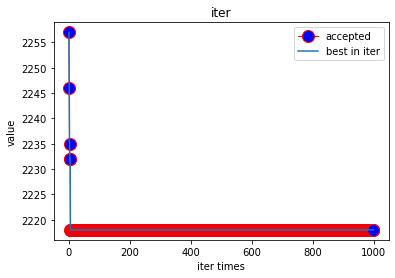

函数:run运行了 47.14536762237549秒


In [53]:
thisSolution,thisLength,saveInit = run(thisSolution, thisLength, 20, 1000, 250)

thisSolution,thisLength = run(thisSolution, thisLength, 3, 100, 25000)

### 消融实验 学习率衰减的**作用**


函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.89it/s]


best_value_final: 2246
[[[16, 15], 2246], [[15, 14], 2246]]
[9, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 34, 35, 14, 16, 45, 20, 38, 0, 10, 11, 8, 32, 6, 29, 30, 5, 31, 7, 23, 13, 46, 36, 15, 17, 12, 37, 39, 19, 44, 21]


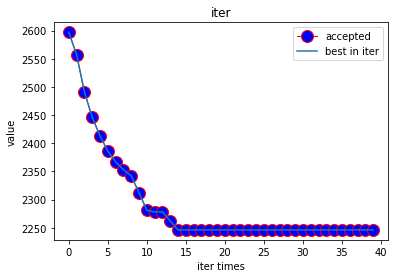

函数:run运行了 2.1127426624298096秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


best_value_final: 2246
[[[16, 15], 2246], [[15, 14], 2246]]
[9, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 34, 35, 14, 16, 45, 20, 38, 0, 10, 11, 8, 32, 6, 29, 30, 5, 31, 7, 23, 13, 46, 36, 15, 17, 12, 37, 39, 19, 44, 21]


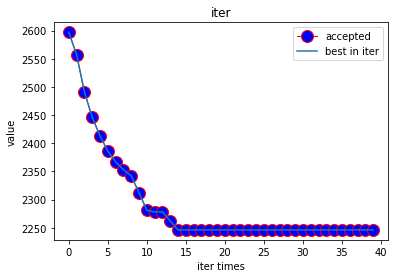

函数:run运行了 2.133932113647461秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 21.41it/s]


best_value_final: 2364
[[[17, 46], 2364], [[36, 46], 2364], [[37, 38], 2364]]
[21, 40, 47, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 20, 38, 37, 18, 17, 15, 16, 45, 39, 26, 1, 0, 25, 11, 46, 36, 14, 23, 12, 13, 34, 35, 19, 44]


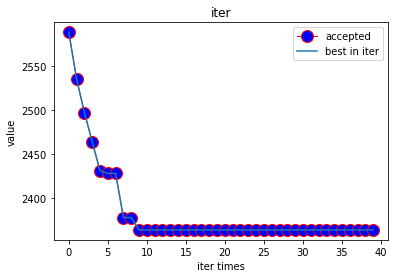

函数:run运行了 2.0464260578155518秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 21.18it/s]


best_value_final: 2327
[[[18, 38], 2327], [[17, 18], 2327]]
[21, 40, 47, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 20, 18, 46, 36, 14, 15, 16, 45, 39, 26, 1, 0, 25, 11, 37, 38, 17, 23, 12, 13, 34, 35, 19, 44]


函数:run运行了 2.0849006175994873秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 21.04it/s]


best_value_final: 2254
[[[6, 10], 2254], [[8, 11], 2254]]
[44, 21, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 10, 11, 8, 32, 7, 31, 9, 2, 41, 43, 22, 20, 38, 18, 17, 36, 14, 16, 45, 15, 35, 34, 13, 46, 23, 12, 6, 0, 25, 1, 37, 39, 19]


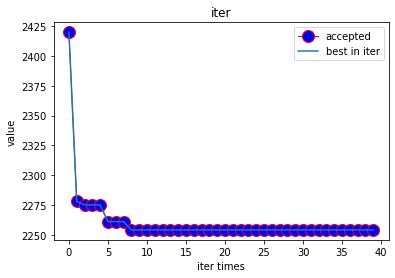

函数:run运行了 2.10485577583313秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 21.24it/s]


best_value_final: 2254
[[[6, 10], 2254], [[11, 8], 2254]]
[44, 21, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 10, 11, 8, 32, 7, 31, 9, 2, 41, 43, 22, 20, 38, 18, 17, 36, 14, 16, 45, 15, 35, 34, 13, 46, 23, 12, 6, 0, 25, 1, 37, 39, 19]


函数:run运行了 2.0903162956237793秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.96it/s]


best_value_final: 2169
[[[15, 16], 2169], [[37, 38], 2169]]
[12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 14, 16, 45, 38, 37, 0, 10, 11, 8, 9, 29, 30, 5, 31, 7, 23, 34, 13, 46, 36, 15, 39, 21, 20, 19, 44]


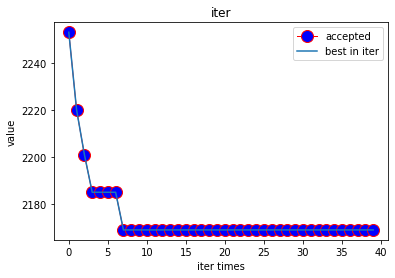

函数:run运行了 2.096709966659546秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


best_value_final: 2169
[[[37, 38], 2169], [[16, 15], 2169]]
[12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 14, 15, 45, 37, 38, 0, 10, 11, 8, 9, 29, 30, 5, 31, 7, 23, 34, 13, 46, 36, 16, 39, 21, 20, 19, 44]


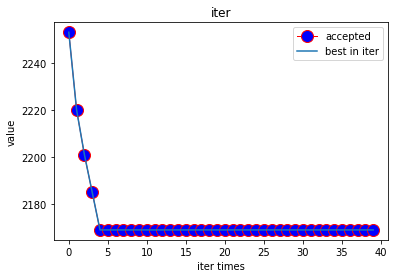

函数:run运行了 2.1184146404266357秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.90it/s]


best_value_final: 2209
[[[3, 29], 2209], [[29, 4], 2209]]
[31, 5, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 14, 16, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 10, 11, 8, 7, 23, 34, 13, 46, 36, 15, 19, 44, 12, 32]


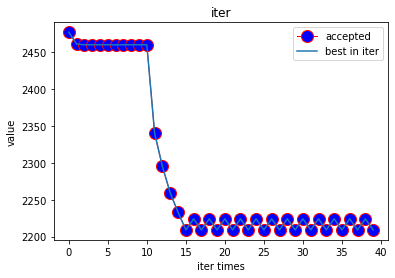

函数:run运行了 2.122689962387085秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.65it/s]


best_value_final: 2209
[[[4, 29], 2209], [[29, 3], 2209]]
[31, 5, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 14, 16, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 10, 11, 8, 7, 23, 34, 13, 46, 36, 15, 19, 44, 12, 32]


函数:run运行了 2.134895086288452秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.82it/s]


best_value_final: 2218
[[[38, 18], 2218], [[19, 44], 2218]]
[46, 36, 14, 16, 45, 20, 38, 17, 12, 23, 34, 35, 15, 44, 19, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 37, 18, 13]


函数:run运行了 2.145139455795288秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.97it/s]


best_value_final: 2218
[[[44, 19], 2218], [[37, 38], 2218]]
[46, 36, 14, 16, 45, 20, 37, 38, 12, 23, 34, 35, 15, 19, 44, 39, 21, 40, 47, 26, 22, 41, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 0, 25, 11, 18, 17, 13]


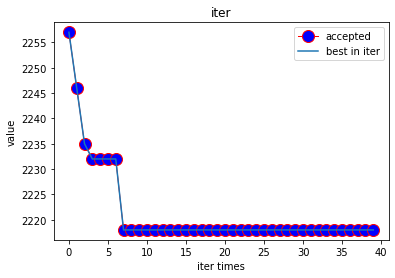

函数:run运行了 2.1267576217651367秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 21.17it/s]


best_value_final: 2200
[[[14, 35], 2200], [[23, 16], 2200]]
[15, 45, 20, 38, 18, 17, 36, 35, 14, 23, 34, 13, 46, 16, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 10, 11, 8, 9, 29, 30, 7, 31, 5, 37, 39, 21, 19, 44]


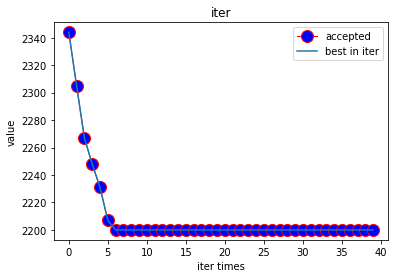

函数:run运行了 2.0858559608459473秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.25it/s]


best_value_final: 2200
[[[35, 14], 2200], [[23, 16], 2200]]
[15, 45, 20, 38, 18, 17, 36, 35, 14, 23, 34, 13, 46, 16, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 10, 11, 8, 9, 29, 30, 7, 31, 5, 37, 39, 21, 19, 44]


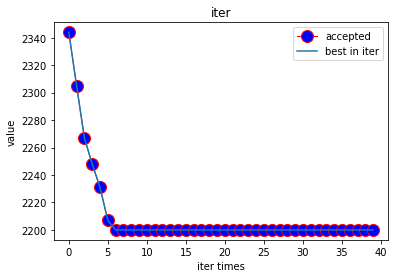

函数:run运行了 2.188100814819336秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.63it/s]


best_value_final: 2165
[[[35, 14], 2165], [[17, 18], 2165]]
[44, 15, 16, 45, 20, 38, 18, 46, 36, 14, 35, 34, 13, 7, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 39, 21, 9, 29, 30, 31, 5, 10, 8, 11, 17, 19]


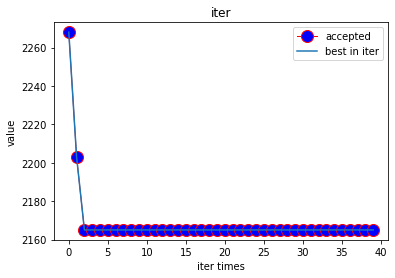

函数:run运行了 2.14510440826416秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.59it/s]


best_value_final: 2165
[[[18, 17], 2165], [[5, 31], 2165]]
[44, 15, 16, 45, 20, 38, 18, 46, 36, 35, 14, 34, 13, 7, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 17, 39, 21, 9, 29, 30, 31, 5, 10, 8, 11, 37, 19]


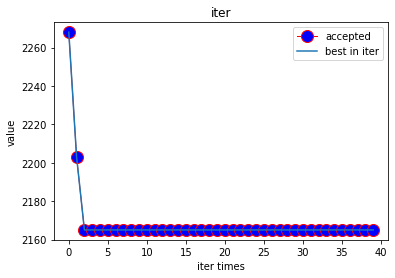

函数:run运行了 2.150373697280884秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.99it/s]


best_value_final: 2344
[[[19, 44], 2344], [[15, 16], 2344]]
[11, 8, 10, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 14, 16, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 5, 31, 7, 23, 34, 13, 46, 36, 15, 12, 32, 19, 44]


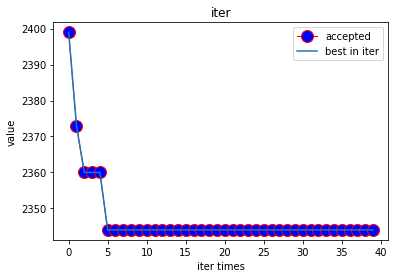

函数:run运行了 2.1096887588500977秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.42it/s]


best_value_final: 2344
[[[14, 15], 2344], [[16, 15], 2344], [[19, 44], 2344]]
[11, 8, 10, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 15, 16, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 5, 31, 7, 23, 34, 13, 46, 36, 14, 12, 32, 44, 19]


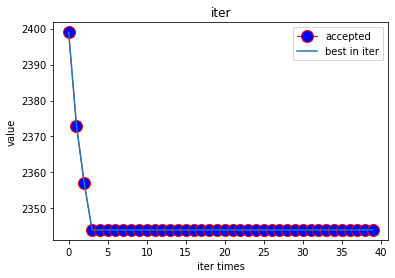

函数:run运行了 2.1627461910247803秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.32it/s]


best_value_final: 2096
[[[45, 14], 2096], [[15, 19], 2096]]
[32, 31, 5, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 37, 18, 17, 35, 14, 39, 21, 20, 38, 0, 25, 10, 11, 8, 9, 29, 30, 7, 23, 34, 13, 46, 36, 45, 19, 44, 15, 16, 12]


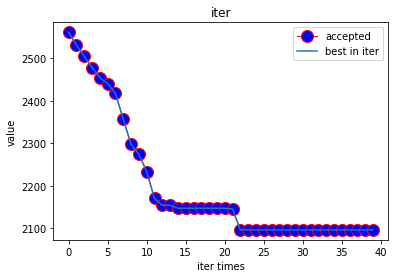

函数:run运行了 2.1685726642608643秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.29it/s]


best_value_final: 2147
[[[13, 34], 2147], [[15, 35], 2145]]
[32, 31, 5, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 37, 18, 17, 13, 35, 39, 21, 20, 38, 0, 25, 10, 11, 8, 9, 29, 30, 7, 23, 34, 46, 36, 14, 15, 16, 45, 19, 44, 12]


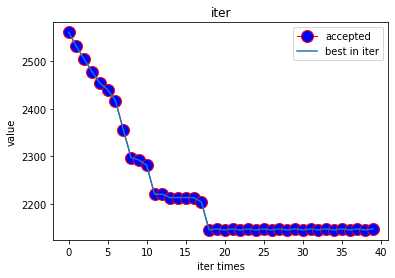

函数:run运行了 2.1726388931274414秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


best_value_final: 2272
[[[10, 6], 2272], [[8, 11], 2272]]
[25, 1, 47, 26, 22, 40, 20, 38, 18, 17, 36, 14, 16, 45, 39, 21, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 10, 11, 8, 32, 7, 31, 9, 2, 41, 43, 19, 44, 15, 35, 34, 13, 46, 23, 12, 6, 37, 0]


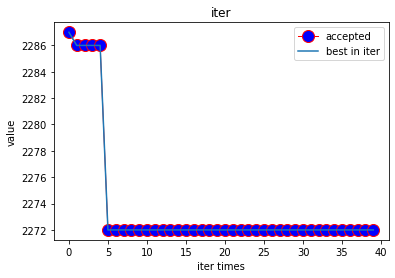

函数:run运行了 2.1529717445373535秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.64it/s]


best_value_final: 2272
[[[1, 25], 2272], [[11, 8], 2272], [[6, 10], 2272]]
[25, 1, 47, 26, 22, 40, 20, 38, 18, 17, 36, 14, 16, 45, 39, 21, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 8, 11, 32, 7, 31, 9, 2, 41, 43, 19, 44, 15, 35, 34, 13, 46, 23, 12, 10, 37, 0]


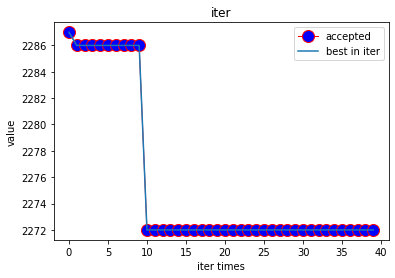

函数:run运行了 2.145146369934082秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.59it/s]


best_value_final: 2253
[[[37, 20], 2253], [[35, 14], 2253]]
[9, 27, 28, 24, 4, 29, 30, 5, 3, 6, 10, 8, 32, 7, 31, 33, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 37, 19, 44, 15, 16, 45, 38, 11, 0, 20, 39, 21, 18, 17, 13, 46, 36, 35, 14, 34, 23, 12]


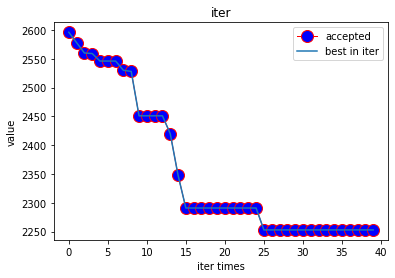

函数:run运行了 2.165971040725708秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.42it/s]


best_value_final: 2488
[[[44, 19], 2488], [[38, 20], 2488]]
[9, 27, 28, 24, 4, 29, 30, 5, 3, 6, 10, 8, 32, 7, 31, 33, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 13, 34, 35, 15, 16, 45, 38, 11, 0, 37, 39, 21, 20, 18, 17, 46, 36, 14, 23, 12, 19, 44]


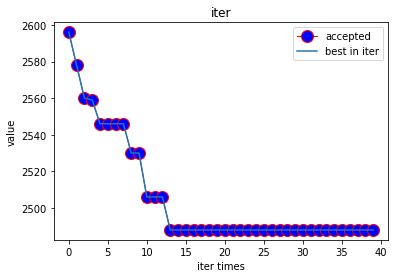

函数:run运行了 2.1648683547973633秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.06it/s]


best_value_final: 2233
[[[33, 3], 2233], [[16, 15], 2233]]
[9, 33, 4, 3, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 34, 35, 14, 16, 45, 20, 38, 0, 10, 11, 8, 32, 6, 24, 29, 30, 5, 31, 7, 23, 13, 46, 36, 15, 17, 12, 37, 39, 19, 44, 21]


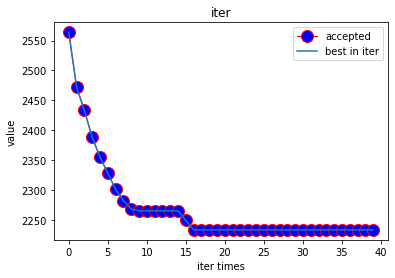

函数:run运行了 2.1872260570526123秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.16it/s]


best_value_final: 2233
[[[15, 14], 2233], [[3, 33], 2233]]
[9, 33, 4, 3, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 34, 35, 14, 16, 45, 20, 38, 0, 10, 11, 8, 32, 6, 24, 29, 30, 5, 31, 7, 23, 13, 46, 36, 15, 17, 12, 37, 39, 19, 44, 21]


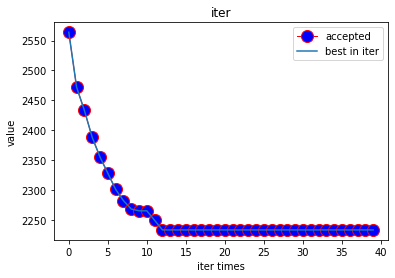

函数:run运行了 2.180432081222534秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.50it/s]


best_value_final: 2195
[[[6, 5], 2195], [[10, 6], 2195]]
[25, 1, 9, 33, 27, 28, 3, 24, 4, 29, 30, 5, 10, 11, 8, 32, 7, 31, 6, 37, 47, 26, 22, 40, 20, 38, 18, 17, 36, 14, 16, 45, 39, 21, 42, 2, 41, 43, 19, 44, 15, 35, 34, 13, 46, 23, 12, 0]


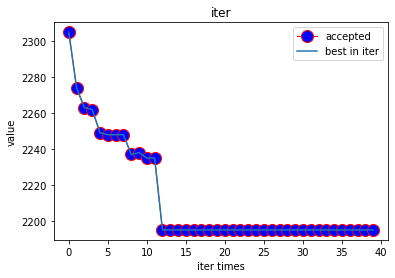

函数:run运行了 2.164344310760498秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.71it/s]


best_value_final: 2195
[[[5, 6], 2195], [[10, 6], 2195]]
[25, 1, 9, 33, 27, 28, 3, 24, 4, 29, 30, 5, 10, 11, 8, 32, 7, 31, 6, 37, 47, 26, 22, 40, 20, 38, 18, 17, 36, 14, 16, 45, 39, 21, 42, 2, 41, 43, 19, 44, 15, 35, 34, 13, 46, 23, 12, 0]


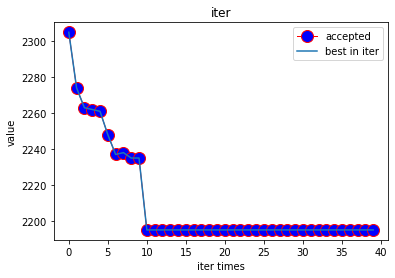

函数:run运行了 2.254110813140869秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.78it/s]


best_value_final: 2210
[[[31, 5], 2210], [[8, 11], 2210]]
[15, 35, 16, 45, 20, 38, 18, 17, 46, 36, 14, 34, 13, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 39, 21, 9, 29, 30, 5, 31, 10, 11, 8, 7, 23, 19, 44]


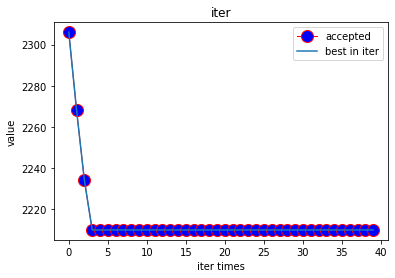

函数:run运行了 2.3371050357818604秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s]


best_value_final: 2210
[[[5, 31], 2210], [[11, 8], 2210]]
[15, 35, 16, 45, 20, 38, 18, 17, 46, 36, 14, 34, 13, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 39, 21, 9, 29, 30, 5, 31, 10, 11, 8, 7, 23, 19, 44]


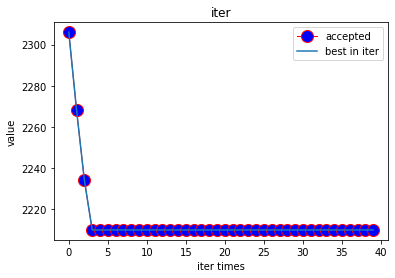

函数:run运行了 2.27431058883667秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.49it/s]


best_value_final: 2422
[[[8, 11], 2422], [[19, 44], 2422]]
[24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 36, 14, 35, 16, 45, 20, 38, 0, 37, 39, 21, 9, 6, 11, 8, 32, 7, 31, 29, 30, 5, 10, 17, 34, 23, 12, 13, 46, 15, 19, 44]


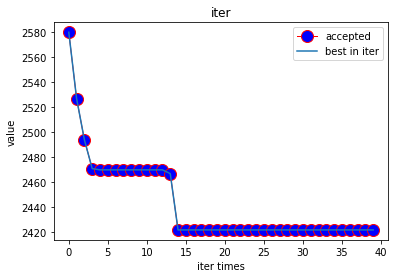

函数:run运行了 2.2669765949249268秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.29it/s]


best_value_final: 2433
[[[19, 44], 2433], [[6, 10], 2433]]
[24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 46, 36, 14, 15, 16, 45, 20, 38, 0, 37, 39, 21, 9, 10, 11, 8, 32, 7, 31, 29, 30, 5, 6, 18, 17, 23, 12, 13, 34, 35, 44, 19]


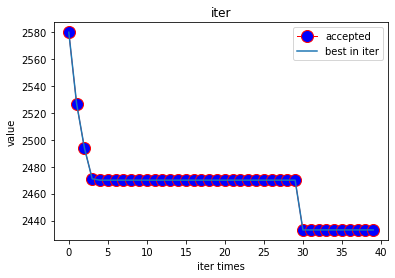

函数:run运行了 2.187021017074585秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.10it/s]


best_value_final: 2397
[[[18, 17], 2397], [[14, 36], 2397], [[37, 38], 2397]]
[21, 47, 22, 40, 20, 38, 37, 17, 36, 15, 16, 45, 39, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 1, 0, 25, 11, 18, 12, 13, 46, 14, 23, 34, 35, 19, 44]


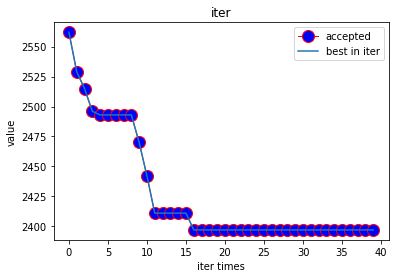

函数:run运行了 2.206996440887451秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.32it/s]


best_value_final: 2421
[[[18, 17], 2421], [[18, 38], 2421]]
[21, 47, 22, 40, 20, 18, 13, 34, 35, 15, 16, 45, 39, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 1, 0, 25, 11, 37, 38, 17, 46, 36, 14, 23, 12, 19, 44]


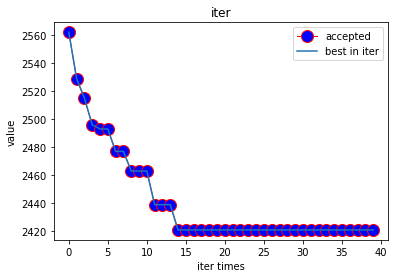

函数:run运行了 2.1691582202911377秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.39it/s]


best_value_final: 2316
[[[37, 18], 2316], [[37, 38], 2316], [[35, 14], 2316]]
[21, 40, 47, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 20, 38, 18, 36, 35, 14, 16, 45, 39, 26, 1, 0, 25, 11, 37, 17, 34, 23, 12, 13, 46, 15, 19, 44]


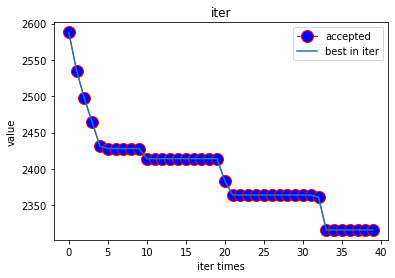

函数:run运行了 2.1563315391540527秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.44it/s]


best_value_final: 2316
[[[38, 37], 2316], [[18, 37], 2316], [[17, 18], 2316]]
[21, 40, 47, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 20, 37, 38, 36, 35, 14, 16, 45, 39, 26, 1, 0, 25, 11, 18, 17, 34, 23, 12, 13, 46, 15, 19, 44]


函数:run运行了 2.169567108154297秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.24it/s]


best_value_final: 2216
[[[34, 13], 2216], [[3, 5], 2216]]
[18, 17, 35, 14, 16, 45, 20, 38, 0, 25, 1, 9, 33, 27, 28, 24, 4, 29, 30, 3, 6, 10, 11, 8, 32, 7, 31, 5, 37, 40, 47, 26, 22, 42, 2, 41, 43, 19, 44, 15, 23, 12, 34, 13, 46, 36, 39, 21]


函数:run运行了 2.189650297164917秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.32it/s]


best_value_final: 2216
[[[34, 13], 2216], [[23, 12], 2216]]
[18, 17, 35, 14, 16, 45, 20, 38, 0, 25, 1, 9, 33, 27, 28, 24, 4, 29, 30, 3, 6, 10, 11, 8, 32, 7, 31, 5, 37, 40, 47, 26, 22, 42, 2, 41, 43, 19, 44, 15, 23, 12, 34, 13, 46, 36, 39, 21]


函数:run运行了 2.182528257369995秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.28it/s]


best_value_final: 2432
[[[19, 44], 2432], [[38, 20], 2432]]
[42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 22, 40, 47, 26, 1, 25, 13, 34, 35, 15, 16, 45, 20, 11, 0, 37, 19, 44, 38, 18, 17, 46, 36, 14, 23, 12, 39, 21]


函数:run运行了 2.175238847732544秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.43it/s]


best_value_final: 2432
[[[44, 19], 2432], [[20, 38], 2432]]
[42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 22, 40, 47, 26, 1, 25, 13, 34, 35, 15, 16, 45, 20, 11, 0, 37, 19, 44, 38, 18, 17, 46, 36, 14, 23, 12, 39, 21]


函数:run运行了 2.1750552654266357秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.48it/s]


best_value_final: 2195
[[[6, 10], 2195], [[6, 5], 2195]]
[25, 1, 9, 33, 27, 28, 3, 24, 4, 29, 30, 5, 10, 11, 8, 32, 7, 31, 6, 37, 47, 26, 22, 40, 20, 38, 18, 17, 36, 14, 16, 45, 39, 21, 42, 2, 41, 43, 19, 44, 15, 35, 34, 13, 46, 23, 12, 0]


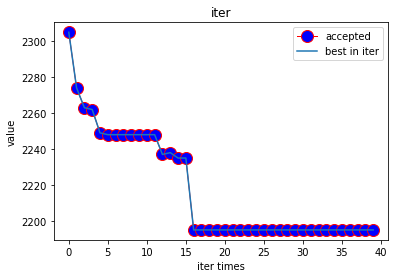

函数:run运行了 2.1670141220092773秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.28it/s]


best_value_final: 2195
[[[6, 10], 2195], [[5, 6], 2195]]
[25, 1, 9, 33, 27, 28, 3, 24, 4, 29, 30, 5, 10, 11, 8, 32, 7, 31, 6, 37, 47, 26, 22, 40, 20, 38, 18, 17, 36, 14, 16, 45, 39, 21, 42, 2, 41, 43, 19, 44, 15, 35, 34, 13, 46, 23, 12, 0]


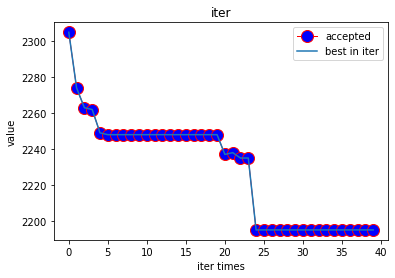

函数:run运行了 2.182098627090454秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s]


best_value_final: 2378
[[[34, 17], 2378], [[20, 38], 2378]]
[42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 22, 40, 47, 26, 1, 25, 34, 35, 14, 15, 16, 45, 20, 11, 0, 37, 44, 19, 38, 18, 17, 23, 12, 13, 46, 36, 39, 21]


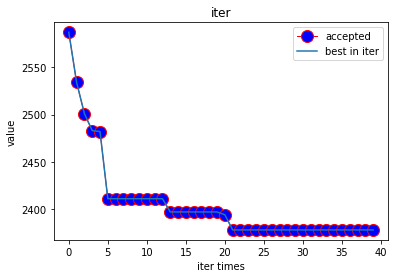

函数:run运行了 2.244663953781128秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.04it/s]


best_value_final: 2378
[[[17, 18], 2378], [[38, 20], 2378], [[44, 19], 2378]]
[42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 22, 40, 47, 26, 1, 25, 17, 35, 14, 15, 16, 45, 38, 11, 0, 37, 44, 19, 20, 18, 34, 23, 12, 13, 46, 36, 39, 21]


函数:run运行了 2.189776659011841秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.13it/s]


best_value_final: 2210
[[[11, 8], 2210], [[35, 14], 2210]]
[40, 47, 26, 22, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 11, 8, 32, 7, 31, 9, 2, 41, 19, 44, 15, 16, 45, 20, 38, 18, 17, 36, 14, 35, 34, 13, 46, 23, 12, 10, 0, 25, 1, 37, 39, 21]


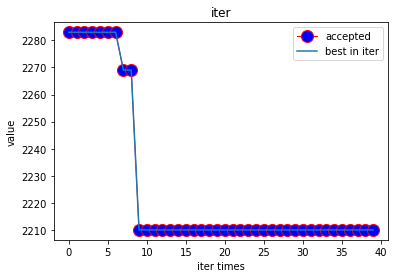

函数:run运行了 2.1935880184173584秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.96it/s]


best_value_final: 2210
[[[6, 10], 2210], [[8, 11], 2210], [[35, 14], 2210]]
[40, 47, 26, 22, 43, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 10, 11, 8, 32, 7, 31, 9, 2, 41, 19, 44, 15, 16, 45, 20, 38, 18, 17, 36, 35, 14, 34, 13, 46, 23, 12, 6, 0, 25, 1, 37, 39, 21]


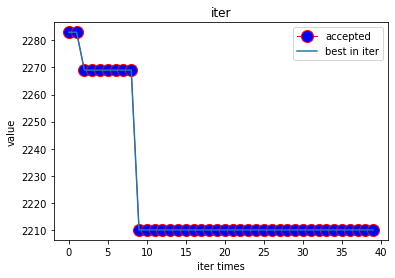

函数:run运行了 2.2160396575927734秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:01<00:00, 20.49it/s]


best_value_final: 2323
[[[17, 18], 2323], [[6, 10], 2323]]
[10, 24, 3, 9, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 18, 13, 34, 35, 15, 16, 45, 20, 38, 0, 25, 11, 8, 32, 7, 31, 5, 4, 29, 30, 6, 37, 17, 46, 36, 14, 23, 12, 39, 19, 44, 21]


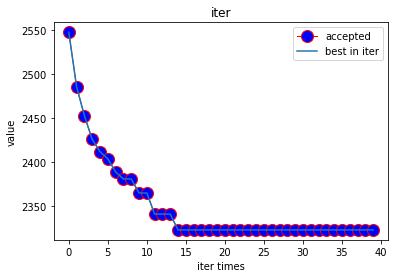

函数:run运行了 2.1662511825561523秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


best_value_final: 2323
[[[18, 17], 2323], [[18, 37], 2323], [[10, 6], 2323]]
[6, 24, 3, 9, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 17, 13, 34, 35, 15, 16, 45, 20, 38, 0, 25, 11, 8, 32, 7, 31, 5, 4, 29, 30, 10, 37, 18, 46, 36, 14, 23, 12, 39, 19, 44, 21]


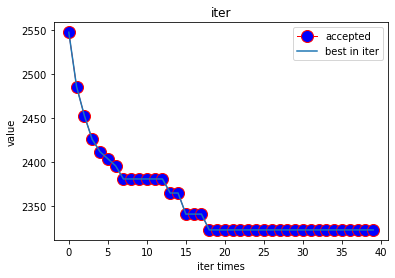

函数:run运行了 2.2481558322906494秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s]


best_value_final: 2458
[[[24, 4], 2458], [[35, 15], 2458]]
[41, 43, 22, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 25, 18, 17, 46, 36, 15, 45, 38, 11, 0, 37, 39, 21, 20, 16, 14, 23, 12, 13, 34, 35, 19, 44]


函数:run运行了 2.2487730979919434秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s]


best_value_final: 2458
[[[24, 4], 2458], [[15, 35], 2458]]
[41, 43, 22, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 25, 18, 17, 46, 36, 15, 45, 38, 11, 0, 37, 39, 21, 20, 16, 14, 23, 12, 13, 34, 35, 19, 44]


函数:run运行了 2.277644395828247秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.42it/s]


best_value_final: 2308
[[[38, 37], 2308], [[18, 17], 2308]]
[20, 38, 37, 17, 36, 15, 16, 45, 39, 21, 40, 47, 26, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 1, 0, 25, 11, 18, 12, 13, 46, 14, 23, 34, 35, 19, 44]


函数:run运行了 2.2649009227752686秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s]


best_value_final: 2232
[[[44, 39], 2232], [[45, 15], 2232]]
[20, 38, 11, 37, 16, 45, 44, 19, 39, 21, 40, 47, 26, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 1, 0, 25, 18, 17, 12, 13, 46, 36, 14, 23, 34, 35, 15]


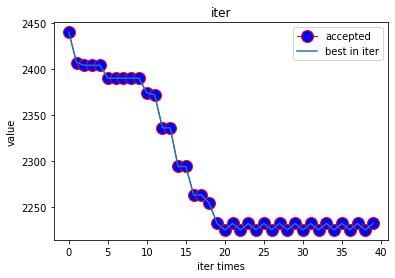

函数:run运行了 2.246269702911377秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]


best_value_final: 2350
[[[36, 17], 2350], [[36, 14], 2350], [[31, 5], 2350]]
[11, 10, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 36, 14, 15, 16, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 5, 31, 6, 8, 32, 7, 23, 46, 17, 12, 13, 34, 35, 19, 44]


函数:run运行了 2.2584803104400635秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.83it/s]


best_value_final: 2350
[[[44, 19], 2350], [[31, 5], 2350]]
[11, 10, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 36, 14, 15, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 31, 5, 6, 8, 32, 7, 23, 46, 16, 12, 13, 34, 35, 44, 19]


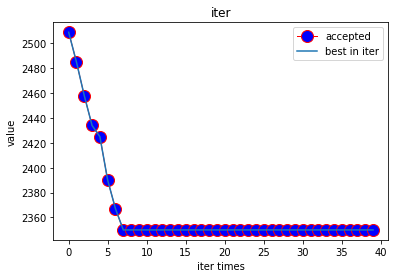

函数:run运行了 2.2284162044525146秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s]


best_value_final: 2165
[[[37, 17], 2165], [[35, 14], 2165], [[31, 5], 2165]]
[44, 15, 16, 45, 20, 38, 18, 46, 36, 14, 35, 34, 13, 7, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 17, 39, 21, 9, 29, 30, 5, 31, 10, 8, 11, 37, 19]


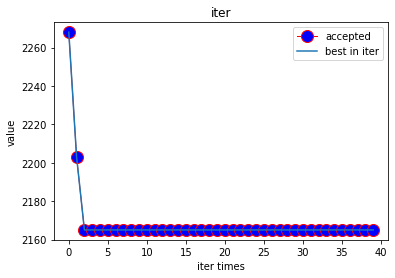

函数:run运行了 2.2831101417541504秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.24it/s]


best_value_final: 2165
[[[14, 35], 2165], [[18, 37], 2165]]
[44, 15, 16, 45, 20, 38, 17, 46, 36, 35, 14, 34, 13, 7, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 39, 21, 9, 29, 30, 31, 5, 10, 8, 11, 18, 19]


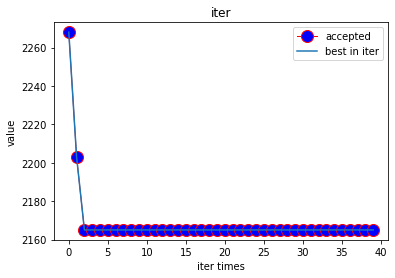

函数:run运行了 2.2884483337402344秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.26it/s]


best_value_final: 2226
[[[45, 16], 2226], [[17, 13], 2226]]
[15, 13, 34, 35, 14, 45, 16, 18, 17, 46, 36, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 38, 20, 39, 21, 9, 29, 30, 7, 31, 5, 8, 11, 10, 19, 44]


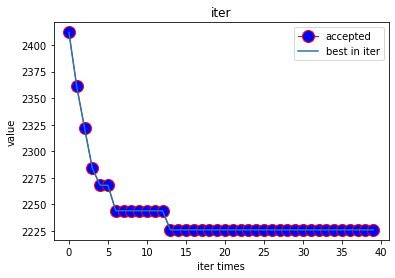

函数:run运行了 2.41515851020813秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.08it/s]


best_value_final: 2226
[[[16, 45], 2226], [[13, 17], 2226]]
[15, 13, 34, 35, 14, 45, 16, 18, 17, 46, 36, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 38, 20, 39, 21, 9, 29, 30, 7, 31, 5, 8, 11, 10, 19, 44]


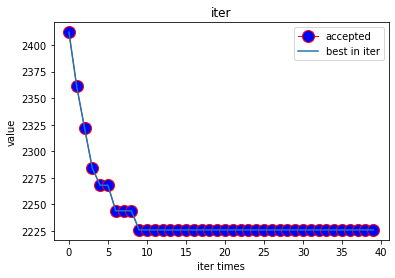

函数:run运行了 2.3068509101867676秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.28it/s]


best_value_final: 2208
[[[1, 25], 2208], [[6, 3], 2208]]
[9, 33, 27, 28, 24, 4, 29, 30, 5, 3, 6, 10, 11, 8, 7, 31, 37, 0, 1, 25, 47, 26, 22, 40, 20, 38, 18, 17, 36, 14, 16, 45, 39, 21, 42, 2, 41, 43, 19, 44, 15, 35, 34, 13, 46, 23, 12, 32]


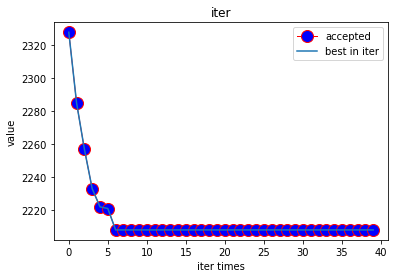

函数:run运行了 2.2837064266204834秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


best_value_final: 2208
[[[25, 1], 2208], [[3, 6], 2208]]
[9, 33, 27, 28, 24, 4, 29, 30, 5, 3, 6, 10, 11, 8, 7, 31, 37, 0, 1, 25, 47, 26, 22, 40, 20, 38, 18, 17, 36, 14, 16, 45, 39, 21, 42, 2, 41, 43, 19, 44, 15, 35, 34, 13, 46, 23, 12, 32]


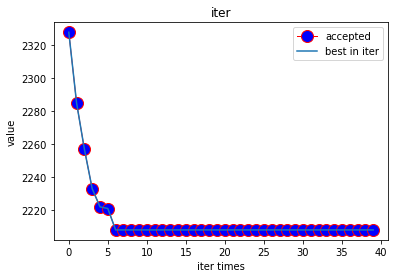

函数:run运行了 2.2584917545318604秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.48it/s]


best_value_final: 2248
[[[10, 8], 2248], [[11, 10], 2250]]
[34, 35, 15, 16, 45, 20, 38, 18, 17, 13, 46, 36, 14, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 39, 21, 9, 29, 30, 7, 31, 5, 10, 8, 11, 19, 44]


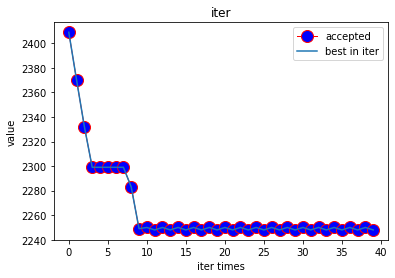

函数:run运行了 2.3892242908477783秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.51it/s]


best_value_final: 2248
[[[10, 8], 2248], [[11, 10], 2250]]
[34, 35, 15, 16, 45, 20, 38, 18, 17, 13, 46, 36, 14, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 39, 21, 9, 29, 30, 7, 31, 5, 10, 8, 11, 19, 44]


函数:run运行了 2.3936352729797363秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.46it/s]


best_value_final: 2521
[[[38, 20], 2521], [[17, 13], 2521]]
[41, 43, 22, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 25, 13, 34, 35, 15, 16, 45, 20, 11, 0, 37, 39, 21, 38, 18, 17, 46, 36, 14, 23, 12, 19, 44]


函数:run运行了 2.38336181640625秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.22it/s]


best_value_final: 2497
[[[38, 20], 2497], [[36, 14], 2497]]
[41, 43, 22, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 25, 18, 17, 36, 15, 16, 45, 20, 11, 0, 37, 39, 21, 38, 12, 13, 46, 14, 23, 34, 35, 19, 44]


函数:run运行了 2.4210729598999023秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.66it/s]


best_value_final: 2165
[[[18, 17], 2165], [[31, 5], 2165]]
[44, 15, 16, 45, 20, 38, 18, 46, 36, 14, 35, 34, 13, 7, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 17, 39, 21, 9, 29, 30, 5, 31, 10, 8, 11, 37, 19]


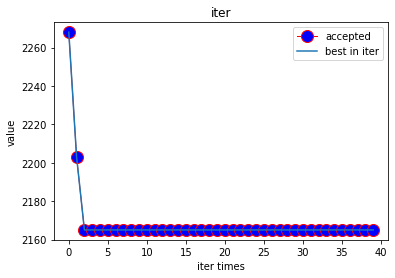

函数:run运行了 2.3628485202789307秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.60it/s]


best_value_final: 2165
[[[14, 35], 2165], [[18, 17], 2165]]
[44, 15, 16, 45, 20, 38, 18, 46, 36, 35, 14, 34, 13, 7, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 17, 39, 21, 9, 29, 30, 31, 5, 10, 8, 11, 37, 19]


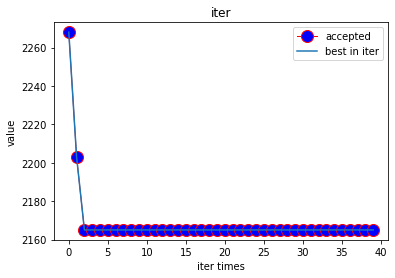

函数:run运行了 2.3857548236846924秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.26it/s]


best_value_final: 2189
[[[31, 5], 2189], [[18, 17], 2189]]
[15, 45, 20, 38, 18, 46, 36, 14, 35, 16, 13, 34, 7, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 17, 39, 21, 9, 29, 30, 31, 5, 10, 8, 11, 37, 19, 44]


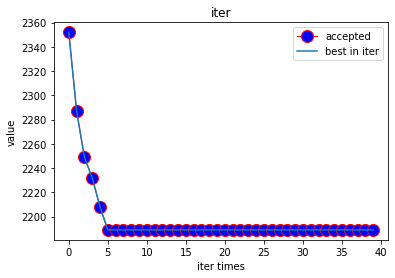

函数:run运行了 2.4157180786132812秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.55it/s]


best_value_final: 2189
[[[18, 17], 2189], [[5, 31], 2189]]
[15, 45, 20, 38, 18, 46, 36, 14, 35, 16, 13, 34, 7, 23, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 39, 21, 9, 29, 30, 5, 31, 10, 8, 11, 17, 19, 44]


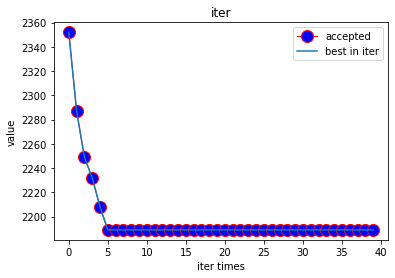

函数:run运行了 2.3770058155059814秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.20it/s]


best_value_final: 2148
[[[38, 37], 2148], [[37, 20], 2148]]
[20, 14, 15, 16, 45, 37, 38, 18, 17, 46, 36, 34, 13, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 0, 25, 1, 10, 11, 8, 9, 29, 30, 5, 31, 7, 23, 35, 39, 19, 44, 21]


函数:run运行了 2.294670820236206秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.62it/s]


best_value_final: 2124
[[[38, 20], 2124], [[35, 37], 2124]]
[20, 37, 15, 16, 45, 38, 18, 17, 46, 36, 14, 34, 13, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 10, 11, 8, 9, 29, 30, 5, 31, 7, 23, 35, 39, 19, 44, 21]


函数:run运行了 2.3718433380126953秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 19.83it/s]


best_value_final: 2194
[[[14, 15], 2194], [[15, 16], 2194]]
[9, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 34, 35, 14, 16, 45, 20, 38, 0, 10, 11, 8, 6, 3, 24, 4, 29, 30, 31, 5, 32, 7, 23, 13, 46, 36, 15, 17, 12, 37, 39, 19, 44, 21]


函数:run运行了 2.2428414821624756秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.59it/s]


best_value_final: 2194
[[[15, 14], 2194], [[5, 31], 2194], [[16, 15], 2194]]
[9, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 34, 35, 15, 16, 45, 20, 38, 0, 10, 11, 8, 6, 3, 24, 4, 29, 30, 5, 31, 32, 7, 23, 13, 46, 36, 14, 17, 12, 37, 39, 19, 44, 21]


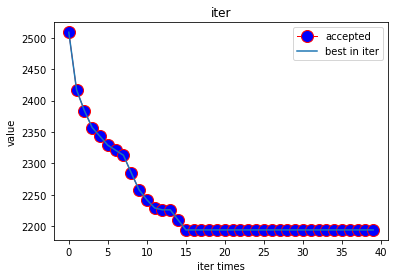

函数:run运行了 2.3686695098876953秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.62it/s]


best_value_final: 2262
[[[14, 36], 2262], [[23, 34], 2262]]
[3, 6, 10, 9, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 37, 18, 17, 36, 15, 16, 45, 20, 38, 0, 25, 11, 8, 32, 7, 31, 24, 4, 29, 30, 5, 12, 13, 46, 14, 23, 34, 35, 39, 19, 44, 21]


函数:run运行了 2.3704323768615723秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.65it/s]


best_value_final: 2323
[[[18, 37], 2323], [[6, 10], 2323], [[18, 17], 2323]]
[6, 24, 3, 9, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 37, 13, 34, 35, 15, 16, 45, 20, 38, 0, 25, 11, 8, 32, 7, 31, 5, 4, 29, 30, 10, 18, 17, 46, 36, 14, 23, 12, 39, 19, 44, 21]


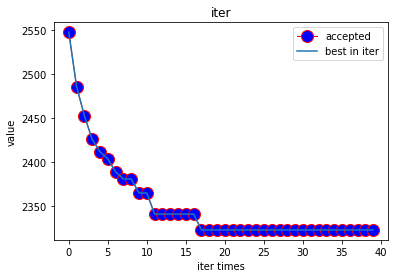

函数:run运行了 2.364182472229004秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.50it/s]


best_value_final: 2521
[[[20, 38], 2521], [[24, 4], 2521]]
[41, 43, 22, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 25, 13, 34, 35, 15, 16, 45, 20, 11, 0, 37, 39, 21, 38, 18, 17, 46, 36, 14, 23, 12, 19, 44]


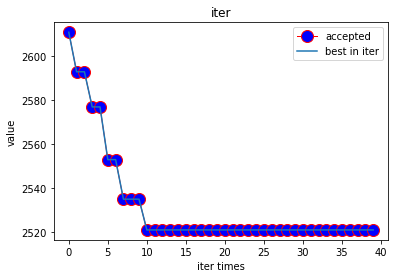

函数:run运行了 2.3816745281219482秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.30it/s]


best_value_final: 2521
[[[20, 38], 2521], [[17, 13], 2521]]
[41, 43, 22, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 1, 25, 13, 34, 35, 15, 16, 45, 20, 11, 0, 37, 39, 21, 38, 18, 17, 46, 36, 14, 23, 12, 19, 44]


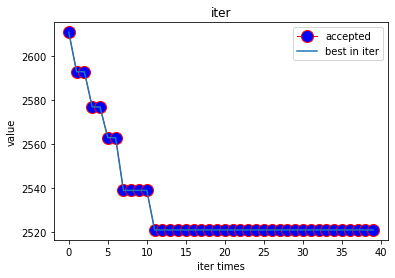

函数:run运行了 2.402217149734497秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.23it/s]


best_value_final: 2203
[[[5, 6], 2203], [[6, 31], 2203]]
[6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 14, 16, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 5, 10, 11, 8, 32, 7, 23, 34, 13, 46, 36, 19, 44, 15, 12, 31]


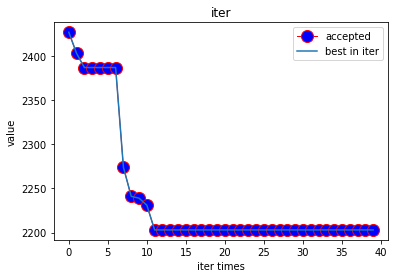

函数:run运行了 2.394749164581299秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.61it/s]


best_value_final: 2209
[[[5, 6], 2209], [[31, 6], 2209]]
[6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 14, 16, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 5, 10, 11, 8, 32, 7, 23, 34, 13, 46, 36, 15, 19, 44, 12, 31]


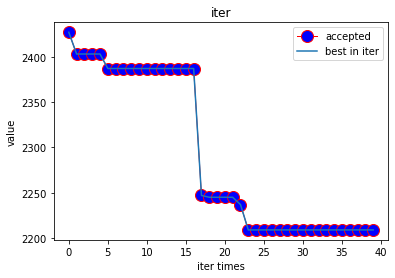

函数:run运行了 2.3636817932128906秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.43it/s]


best_value_final: 2316
[[[14, 35], 2316], [[37, 38], 2316]]
[21, 40, 47, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 20, 37, 38, 36, 35, 14, 16, 45, 39, 26, 1, 0, 25, 11, 18, 17, 34, 23, 12, 13, 46, 15, 19, 44]


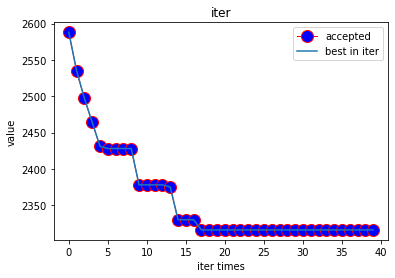

函数:run运行了 2.381336212158203秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.52it/s]


best_value_final: 2350
[[[36, 46], 2350], [[37, 38], 2350]]
[21, 40, 47, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 20, 38, 37, 18, 17, 36, 16, 45, 39, 26, 1, 0, 25, 11, 46, 14, 34, 23, 12, 13, 35, 15, 19, 44]


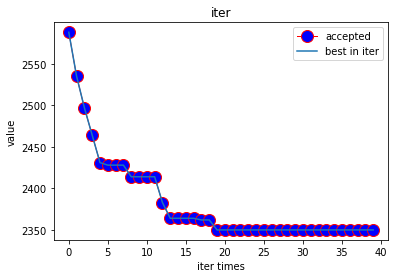

函数:run运行了 2.3595571517944336秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.22it/s]


best_value_final: 2133
[[[6, 8], 2133], [[37, 38], 2133]]
[32, 6, 8, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 10, 11, 18, 17, 35, 39, 21, 20, 38, 37, 0, 25, 1, 9, 29, 30, 5, 31, 7, 23, 34, 13, 46, 36, 14, 15, 16, 45, 19, 44, 12]


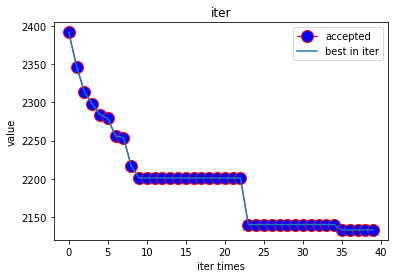

函数:run运行了 2.418391704559326秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.69it/s]


best_value_final: 2167
[[[44, 21], 2167], [[21, 39], 2193], [[20, 21], 2201]]
[32, 6, 8, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 10, 11, 18, 17, 35, 15, 16, 20, 37, 38, 0, 25, 1, 9, 29, 30, 5, 31, 7, 23, 34, 13, 46, 36, 14, 45, 39, 44, 19, 21, 12]


函数:run运行了 2.355478048324585秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.35it/s]


best_value_final: 2266
[[[34, 13], 2266], [[20, 37], 2266]]
[20, 38, 18, 17, 35, 14, 16, 45, 37, 0, 25, 1, 9, 33, 27, 28, 24, 4, 29, 30, 3, 6, 10, 11, 8, 32, 7, 31, 5, 47, 26, 22, 40, 42, 2, 41, 43, 19, 44, 15, 23, 12, 13, 34, 46, 36, 39, 21]


函数:run运行了 2.3991732597351074秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.59it/s]


best_value_final: 2266
[[[34, 13], 2266], [[20, 37], 2266], [[37, 38], 2266]]
[20, 38, 18, 17, 35, 14, 16, 45, 37, 0, 25, 1, 9, 33, 27, 28, 24, 4, 29, 30, 3, 6, 10, 11, 8, 32, 7, 31, 5, 47, 26, 22, 40, 42, 2, 41, 43, 19, 44, 15, 23, 12, 13, 34, 46, 36, 39, 21]


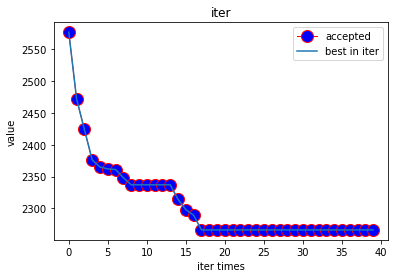

函数:run运行了 2.373009443283081秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.71it/s]


best_value_final: 2276
[[[38, 37], 2276], [[37, 20], 2276]]
[21, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 22, 20, 46, 36, 14, 15, 16, 45, 39, 37, 38, 0, 25, 1, 11, 18, 17, 23, 12, 13, 34, 35, 19, 44]


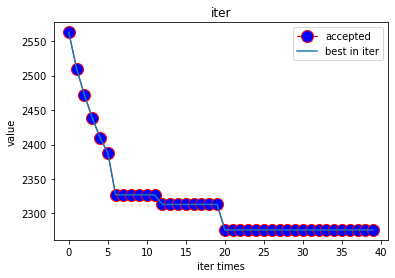

函数:run运行了 2.3502888679504395秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.48it/s]


best_value_final: 2313
[[[46, 17], 2313], [[36, 14], 2313], [[38, 20], 2313]]
[21, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 22, 20, 18, 46, 14, 15, 16, 45, 39, 38, 37, 0, 25, 1, 11, 17, 36, 23, 12, 13, 34, 35, 19, 44]


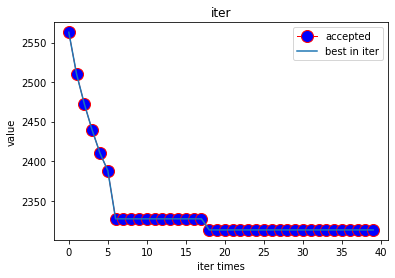

函数:run运行了 2.38806414604187秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.12it/s]


best_value_final: 2315
[[[13, 12], 2315], [[13, 17], 2315]]
[13, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 46, 36, 14, 15, 16, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 31, 5, 10, 8, 11, 18, 17, 12, 7, 23, 34, 35, 19, 44]


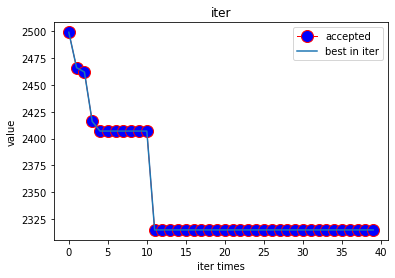

函数:run运行了 2.4617722034454346秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.74it/s]


best_value_final: 2250
[[[5, 31], 2250], [[18, 17], 2250]]
[15, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 17, 46, 36, 14, 16, 45, 20, 38, 0, 37, 39, 21, 9, 29, 30, 31, 5, 10, 8, 11, 18, 12, 7, 23, 13, 34, 35, 19, 44]


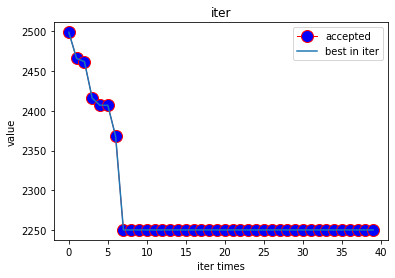

函数:run运行了 2.3400208950042725秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.25it/s]


best_value_final: 2304
[[[37, 38], 2304], [[37, 20], 2304]]
[21, 47, 26, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 40, 38, 46, 36, 14, 15, 16, 45, 39, 20, 37, 0, 25, 1, 11, 18, 17, 23, 12, 13, 34, 35, 19, 44]


函数:run运行了 2.419245958328247秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.05it/s]


best_value_final: 2341
[[[17, 18], 2341], [[36, 14], 2341]]
[21, 47, 26, 22, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 40, 38, 17, 46, 14, 15, 16, 45, 39, 20, 37, 0, 25, 1, 11, 18, 36, 23, 12, 13, 34, 35, 19, 44]


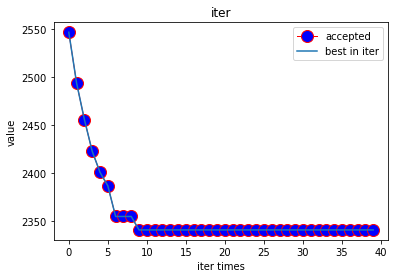

函数:run运行了 2.4257278442382812秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 17.89it/s]


best_value_final: 2305
[[[14, 36], 2305], [[34, 23], 2305]]
[9, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 37, 18, 17, 14, 15, 16, 45, 20, 38, 0, 25, 11, 8, 32, 7, 31, 5, 29, 30, 10, 12, 13, 46, 36, 23, 34, 35, 39, 19, 44, 21]


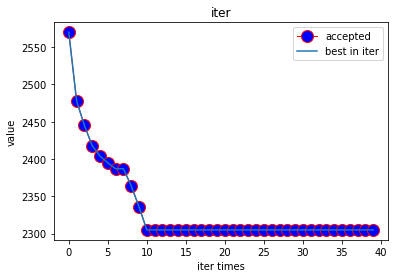

函数:run运行了 2.464768886566162秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 17.62it/s]


best_value_final: 2329
[[[18, 37], 2329], [[18, 17], 2329]]
[9, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 18, 13, 34, 35, 15, 16, 45, 20, 38, 0, 25, 11, 8, 32, 7, 31, 5, 29, 30, 10, 37, 17, 46, 36, 14, 23, 12, 39, 19, 44, 21]


函数:run运行了 2.480991840362549秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.20it/s]


best_value_final: 2218
[[[3, 29], 2218], [[4, 29], 2203]]
[31, 5, 6, 24, 4, 29, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 14, 16, 45, 20, 38, 0, 37, 39, 21, 9, 3, 30, 10, 11, 8, 7, 23, 34, 13, 46, 36, 19, 44, 15, 12, 32]


函数:run运行了 2.4377191066741943秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 17.87it/s]


best_value_final: 2224
[[[29, 3], 2224], [[4, 29], 2209]]
[31, 5, 6, 24, 4, 29, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 35, 14, 16, 45, 20, 38, 0, 37, 39, 21, 9, 3, 30, 10, 11, 8, 7, 23, 34, 13, 46, 36, 15, 19, 44, 12, 32]


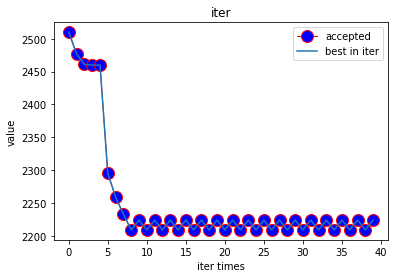

函数:run运行了 2.4485127925872803秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 17.70it/s]


best_value_final: 2405
[[[20, 38], 2405], [[44, 19], 2405]]
[9, 27, 28, 24, 4, 29, 30, 5, 3, 6, 10, 8, 32, 7, 31, 33, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 17, 36, 14, 35, 16, 45, 38, 11, 0, 37, 39, 21, 20, 18, 34, 23, 12, 13, 46, 15, 19, 44]


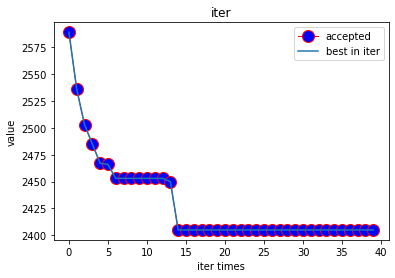

函数:run运行了 2.475498676300049秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.21it/s]


best_value_final: 2425
[[[19, 44], 2425], [[16, 15], 2425]]
[9, 27, 28, 24, 4, 29, 30, 5, 3, 6, 10, 8, 32, 7, 31, 33, 2, 41, 43, 22, 40, 47, 26, 42, 1, 25, 18, 17, 46, 36, 15, 45, 38, 11, 0, 37, 39, 21, 20, 16, 14, 23, 12, 13, 34, 35, 44, 19]


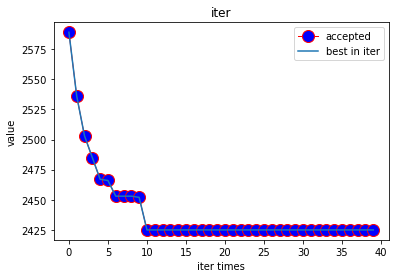

函数:run运行了 2.4292938709259033秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.13it/s]


best_value_final: 2324
[[[38, 37], 2324], [[36, 14], 2324], [[37, 20], 2324]]
[21, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 22, 20, 18, 17, 36, 15, 16, 45, 39, 38, 37, 0, 25, 1, 11, 12, 13, 46, 14, 23, 34, 35, 19, 44]


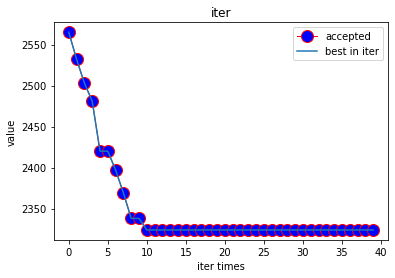

函数:run运行了 2.4276275634765625秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 18.40it/s]


best_value_final: 2271
[[[38, 20], 2271], [[44, 19], 2271]]
[21, 40, 47, 26, 42, 28, 3, 33, 27, 24, 29, 30, 5, 4, 6, 10, 8, 32, 7, 31, 9, 2, 41, 43, 22, 38, 13, 34, 35, 15, 16, 45, 44, 19, 20, 0, 25, 1, 11, 18, 17, 46, 36, 14, 23, 12, 37, 39]


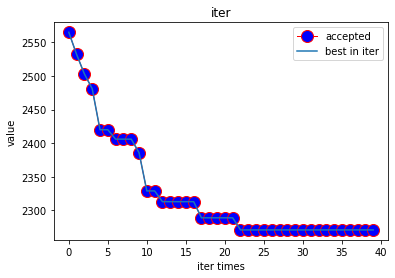

函数:run运行了 2.3941450119018555秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 17.68it/s]


best_value_final: 2210
[[[5, 31], 2210], [[8, 11], 2210]]
[15, 35, 16, 45, 20, 38, 18, 17, 46, 36, 14, 34, 13, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 39, 21, 9, 29, 30, 5, 31, 10, 11, 8, 7, 23, 19, 44]


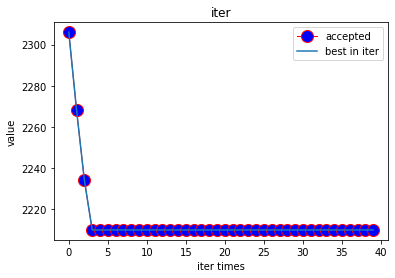

函数:run运行了 2.4948747158050537秒

函数：run开始运行：


Searching: 100%|██████████| 40/40 [00:02<00:00, 17.95it/s]


best_value_final: 2210
[[[5, 31], 2210], [[8, 11], 2210]]
[15, 35, 16, 45, 20, 38, 18, 17, 46, 36, 14, 34, 13, 12, 32, 6, 24, 4, 3, 33, 27, 28, 2, 41, 43, 22, 40, 47, 26, 42, 1, 0, 25, 37, 39, 21, 9, 29, 30, 5, 31, 10, 11, 8, 7, 23, 19, 44]


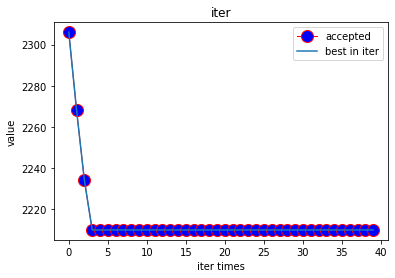

函数:run运行了 2.450927495956421秒


([2246,
  2364,
  2254,
  2169,
  2209,
  2218,
  2200,
  2165,
  2344,
  2096,
  2272,
  2253,
  2233,
  2195,
  2210,
  2422,
  2397,
  2316,
  2216,
  2432,
  2195,
  2378,
  2210,
  2323,
  2458,
  2308,
  2350,
  2165,
  2226,
  2208,
  2248,
  2521,
  2165,
  2189,
  2148,
  2194,
  2262,
  2521,
  2203,
  2316,
  2133,
  2266,
  2276,
  2315,
  2304,
  2305,
  2218,
  2405,
  2324,
  2210],
 [2246,
  2327,
  2254,
  2169,
  2209,
  2218,
  2200,
  2165,
  2344,
  2147,
  2272,
  2488,
  2233,
  2195,
  2210,
  2433,
  2421,
  2316,
  2216,
  2432,
  2195,
  2378,
  2210,
  2323,
  2458,
  2232,
  2350,
  2165,
  2226,
  2208,
  2248,
  2497,
  2165,
  2189,
  2124,
  2194,
  2323,
  2521,
  2209,
  2350,
  2167,
  2266,
  2313,
  2250,
  2341,
  2329,
  2224,
  2425,
  2271,
  2210])

In [54]:
a=[]
b=[]
for i in range(50):
  thisSolution,initlength = generate_first_solution(interCnt=70)
  _,res,_ = run(thisSolution, thisLength, 20, 40, 8000, True, True)
  a.append(res)
  _,res,_ = run(thisSolution, thisLength, 20, 40, 8000, True, False)
  b.append(res)
a,b

# 其他实验

'''
执行一次搜索算法
''' 
优化过程
interate_procedure = []

for cnt in range(maxIter):
    if cnt == 0:
    # 初始化禁忌表
      append_table(banned_Table, initlength, [1,2], tabLength)
      #continue
    # 接受解？
    isAccept = False
    # 按照规则寻找所有邻域，生成二维数组
    # 应该是随机选取
    # axis0为一种方法 axis1为对应的交换
    # 需要交换被记录
    gen = generate_neighborhood(thisSolution)
    exchanged_list = gen['state']
    after_exchange_list = gen['tab']
    
    #print(len(gen['state']))
    # 获取对应所有领域的路径长度
    len_list = cal_length_in_tab(gen['tab'])

    # total = [after_exchange_list,exchanged_list,len_list] 
    # total_rank = total.sort(key= lambda x:x[2]) 
    c = list(zip(after_exchange_list,exchanged_list,len_list))  # 将a,b整体作为一个zip,每个元素一一对应后打乱
    c.sort(key=lambda x: x[:][2])
    #after_exchange_list[:],exchanged_list[:],len_list[:] = zip(*c) # 将打乱的c解开  

    # 相当于 
    k = 0
    
    # 获取最优解
    # best_index_now, best_value_now = get_best_index(len_list)
    best_index_now, best_value_now = k, c[k][2]
    # 最优解对应的交换方式
    #exchanged_couple = exchanged_list[best_index_now]
    exchanged_couple = c[k][1]

    print('best_value_now:', best_value_now)

    
    # 最优破禁
    if min([x[1] for x in banned_Table]) > best_value_now :
        isAccept = True
    # 本轮最好解都没达到以前的
    else:
      # 判断并且更新最优解
      # 破禁检查 
      
      for k in range(1,len(exchanged_list)):
        isExist = check_state_in_banned_table(c[k][1])
        if not isExist:
          # 接受解为当前的k
          isAccept = True
          break

        elif isExist:
          # 寻找次优解
          # total
          if random.random() < random_accept:
            isAccept = True
            break


      # 表没满，无条件增加
      # if tabLength > len(banned_Table):
      #     banned_Table = append_table(banned_Table, best_value_now, exchanged_couple, tabLength)
      # 表满了
      # else:

      # 利用lambda表达式更新表,重新排序
      banned_Table.sort(key = lambda x:x[:][1])
      
      # 最优破禁
      # bug 最开始banned table是空的
      # if min([x[1] for x in banned_Table]) > best_value_now :
      #     isAccept = True
          #banned_Table = append_table(banned_Table, best_value_now, exchanged_couple, tabLength)
      
      # 按照一定概率加入可能的解
      # todo 越接近越可能
      # else:
      #     if random.random() < random_accept:
      #         isAccept = True
              # banned_Table = random_add(banned_Table, best_value_now, exchanged_couple, tabLength)
              # thisSolution = gen['tab'][best_index_now]
    if isAccept:
      thisSolution = gen['tab'][best_index_now]
      print('best_value_accept:', thisSolution)
      banned_Table = append_table(banned_Table, best_value_now, exchanged_couple, tabLength)
      interate_procedure.append(best_value_now)          

print('best_value_final:', best_value_now)
print(banned_Table)
print(thisSolution)
    #banned_Table

p = [1,2,35,6]
p.sort()
p

from matplotlib import pyplot as plt
interate_procedure

'''
执行一次搜索算法
''' 
interate_procedure = []
for cnt in range(maxIter):
    # 按照规则寻找所有邻域，生成二维数组
    # 应该是随机选取
    # axis0为一种方法 axis1为对应的交换
    # 需要交换被记录
    gen = generate_neighborhood(thisSolution)
    exchanged_list = gen['state']
    #print(len(gen['state']))
    # 获取对应所有领域的路径长度
    len_list = cal_length_in_tab(gen['tab'])
    #print(len(len_list))
    
    # 获取最优解
    best_index_now, best_value_now = get_best_index(len_list)
    print('best_value_now:', best_value_now)
    
    if len(banned_Table)>0:
        if min([x[1] for x in banned_Table]) > best_value_now :
            thisSolution = gen['tab'][best_index_now]
            interate_procedure.append(best_value_now)
    
    # 判断并且更新最优解
    # 破禁检查
    exchanged_couple = exchanged_list[best_index_now]
    # 表没满，无条件增加
    if tabLength > len(banned_Table):
        banned_Table = append_table(banned_Table, best_value_now, exchanged_couple, tabLength)
    # 表满了
    else:
        # 利用lambda表达式更新表,重新排序
        banned_Table.sort(key = lambda x:x[:][1])
        
        # 最优破禁
        # bug 最开始banned table是空的
        if min([x[1] for x in banned_Table]) > best_value_now :
            banned_Table = append_table(banned_Table, best_value_now, exchanged_couple, tabLength)
            interate_procedure.append(best_value_now)

        
        # 按照一定概率加入可能的解
        # todo 越接近越可能
        else:
            if random.random()< random_accept:
                banned_Table = random_add(banned_Table, best_value_now, exchanged_couple, tabLength)
                thisSolution = gen['tab'][best_index_now]
                
print('best_value_final:', best_value_now)
print(banned_Table)
print(thisSolution)
    #banned_Table